# Tutorial 3: Computing Unwindowed Power Spectra from BOSS DR12

In this tutorial we will use PolyBin3D to estimate the power spectra of a section of the BOSS DR12 dataset. We will compute both the standard window-convolved and new unwindowed spectra, and discuss various choices of weighting schemes. Much of the data-handling routines in this section are borrowed from the [Nbodykit cookbook](https://nbodykit.readthedocs.io/en/latest/cookbook/index.html). The PolyBin3D code is simple to use, but there's a lot of preliminaries to get through before we can use it. To avoid having to run this code on a cluster, we'll focus on the smallest BOSS data patch, and compute spectra at comparatively low $k$.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [7]:
%pylab inline
import os, sys
from scipy.interpolate import UnivariateSpline, interp1d
from nbodykit.lab import * # for file handling and grid-making [not essential, but useful!]
import healpy as hp # to build a rough angular mask [not essential, but useful!]

import PolyBin3D as pb # the main code [essential!]

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();

Populating the interactive namespace from numpy and matplotlib


### 1. Download the Data

First, we'll download some observational data. Here, we use the SGC LOWZ data (from the SDSS [website](https://data.sdss.org/sas/dr12/boss/lss/)), which is the smallest of the four BOSS DR12 data chunks.

In [8]:
def print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

def download_data(download_dir):
    """Download the FITS data needed for this notebook to the specified directory."""
    from six.moves import urllib
    import shutil
    import gzip

    urls = ['https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_LOWZ_South.fits.gz',
            'https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_LOWZ_South.fits.gz',
           ]
    filenames = ['galaxy_DR12v5_LOWZ_South.fits', 'random0_DR12v5_LOWZ_South.fits']

    # download both files
    for i, url in enumerate(urls):

        # the download path
        filename = url.split('/')[-1]
        file_path = os.path.join(download_dir, filename)
        final_path = os.path.join(download_dir, filenames[i])
        print(final_path)

        # do not re-download
        if not os.path.exists(final_path):
            print("Downloading %s" % url)

            # Check if the download directory exists, otherwise create it.
            if not os.path.exists(download_dir):
                os.makedirs(download_dir)

            # Download the file from the internet.
            file_path, _ = urllib.request.urlretrieve(url=url,
                                                      filename=file_path,
                                                      reporthook=print_download_progress)

            print()
            print("Download finished. Extracting files.")

            # unzip the file
            if url.split('.')[-1]=='gz':
                with gzip.open(file_path, 'rb') as f_in, open(final_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                os.remove(file_path)
                print("Done.")
        else:
            print("Data has already been downloaded.")

# download the data to a specified directory
download_dir = "/Users/ophilcox/Documents/"
download_data(download_dir)

/Users/ophilcox/Documents/galaxy_DR12v5_LOWZ_South.fits
Data has already been downloaded.
/Users/ophilcox/Documents/random0_DR12v5_LOWZ_South.fits
Data has already been downloaded.


### 2. Create Data and Mask

The first step of our computation is to create the density field, containing
$$d(\vec x) = n_g(\vec x)-\alpha\,n_r(\vec x)$$
from the galaxy and random catalog, on a grid (where $\alpha = N_g/N_r$, where $N_i$ is the weighted number of each species). Here, the gridsize is set according to a specified $k_{\rm max}$ value. Since we weight the data via the $\mathsf{S}^{-1}$ operator, we *only* apply systematic weights at this step. Here, our normalization is such that $d$ contains the mean overdensity in each pixel, and we do not apply any pixel-window-deconvolution (i.e. "compensation") - this is done later in PolyBin3D.

In [9]:
### Load BOSS data
download_dir = '/Users/ophilcox/Documents/'
data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')

# Sample parameters
eff_area = 2501.26 # effective area in deg^2 [from Cuesta+16, Tab. 2]
ZMIN = 0.15
ZMAX = 0.43

# initialize the FITS catalog objects for data and randoms
_cat = FITSCatalog(data_path)
_cat_rand = FITSCatalog(randoms_path)

# fix a fiducial cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# Define Cartesian positions for the data
_cat['Position'] = transform.SkyToCartesian(_cat['RA'], _cat['DEC'], _cat['Z'], cosmo=cosmo)
_cat_rand['Position'] = transform.SkyToCartesian(_cat_rand['RA'], _cat_rand['DEC'], _cat_rand['Z'], cosmo=cosmo)

# Define weights
_cat_rand['WEIGHT'] = 1.0
_cat['WEIGHT'] = _cat['WEIGHT_SYSTOT'] * (_cat['WEIGHT_NOZ'] + _cat['WEIGHT_CP'] - 1.0)

# Apply redshift cuts
cat_rand = _cat_rand[(_cat_rand['Z'] >= ZMIN)&(_cat_rand['Z'] < ZMAX)]
cat = _cat[(_cat['Z'] >= ZMIN)&(_cat['Z'] < ZMAX)]

# Define box attributes
kmax = 0.2
boxsize = 1.2*(np.max(cat['Position'].compute(),axis=0)-np.min(cat['Position'].compute(),axis=0))
boxcenter = (np.max(cat['Position'].compute(),axis=0)+np.min(cat['Position'].compute(),axis=0))/2.
gridsize = np.asarray(np.ceil(1.2*kmax/(np.pi/boxsize)),dtype=int)

# Shift data to box-center
cat['Position'] -= boxcenter
cat_rand['Position'] -= boxcenter

# Create data and random meshes
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['WEIGHT']).compute()/boxsize.prod()
mesh_rand = mesh_rand*np.sum(cat_rand['WEIGHT']).compute()/boxsize.prod()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Compute output as [data - alpha * randoms]
density_grid = (mesh_data - alpha*mesh_rand)

We also must create a mask, $n(\vec x)$. Here, we'll use the pixel-window-deconvolved random catalog for this. Another option would be to use the (smooth) observation mask multiplied by the galaxy redshift distribution.

In [10]:
# Create random mesh, removing pixel-window
rand_grid = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=True, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()

# Normalize to match the data
rand_grid = np.asarray(rand_grid)*np.sum(cat['WEIGHT']).compute()/boxsize.prod()

Let's plot the maps:

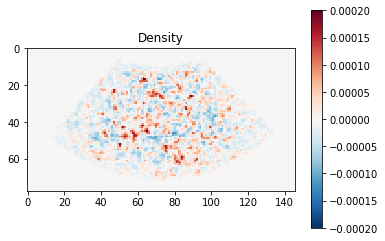

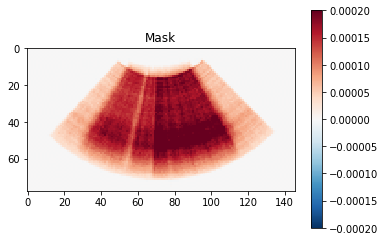

In [11]:
plotter(density_grid,vmax=0.0002,title='Density')
plotter(rand_grid,vmax=0.0002,title='Mask')

### 3. Define weighting
Next, we define a weighting scheme for the data by specifying the $\mathsf{S}^{-1}$ function. Ideally, $$\mathsf{S}^{-1}(\vec x,\vec y) = \left[W\xi+\beta\mathsf{I}\right]^{-1}(\vec x, \vec y)$$ for mask matrix $W$ and data two-point function matrix $\xi$ (with shot-noise specified by $\beta\approx 1$). If the mask contains holes or local lines-of-sight, this cannot be computed analytically. We can either use an approximate weighting $\mathsf{S}^{-1}$ (which does not bias the estimator), or compute the full solution with conjugate gradient descent. 

Here, we'll assume the FKP limit, using $$\mathsf{S}^{-1}(\vec x,\vec y) = \frac{\delta_{\rm D}(\vec x-\vec y)}{n_z(\vec x)P_{\rm FKP}+1} \equiv w_{\rm FKP}(\vec x)\delta_{\rm D}(\vec x-\vec y),$$
where $n_z(\vec x)$ is the (volumetric) redshift distribution, taken from the data. To compute this, we'll first load the PolyBin3D class. This takes the attributes computed above and a few other parameters (such as the choice of pixel window, and our definition of the redshift-axis).

In [17]:
# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, 
                 Pk=None, # fiducial Pk for generating MC simulations (here set to 1 to simplify ideal Fisher matrix)
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )


# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [7.32e+02, 1.49e+01, 2.31e+02] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [78, 146, 82]
# Fundamental frequency: [0.006, 0.003, 0.006] h/Mpc
# Nyquist frequency: [0.242, 0.241, 0.243] h/Mpc
# Pixel window: interlaced-tsc


We then create an interpolator for $n_z(z)$:

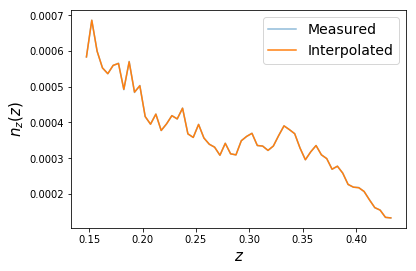

In [19]:
# Histogram the z values, giving dN = n(z)*dz
nz,z = np.histogram(_cat['Z'].compute(),bins=np.arange(ZMIN-0.005,ZMAX+0.0051,0.005),weights=_cat['WEIGHT'].compute(),range=[ZMIN-0.005,ZMAX+0.005])
z_av = 0.5*(z[:-1]+z[1:])
rz = cosmo.comoving_distance(z)

# Convert to volume density i.e. dN = n_z(z)dV
f_sky = eff_area/(4.*np.pi*(180./np.pi)**2.)
volz = 4.*np.pi/3.*(rz[1:]**3.-rz[:-1]**3.)*f_sky
nz_interp = UnivariateSpline(z_av,nz/volz,s=0.00000000001)

# Plot the distribution
plt.plot(z_av, nz/volz, label='Measured',alpha=0.5)
plt.plot(z_av, nz_interp(z_av), label='Interpolated')
plt.xlabel(r'$z$',fontsize=15)
plt.ylabel(r'$n_z(z)$',fontsize=15)
plt.legend(fontsize=14);

Next, we compute a 3D grid of $n_z(\vec x)$, and the $\mathsf{S}^{-1}$ function itself. Note that this must take real- or Fourier-space inputs and outputs (to avoid unnecessary Fourier-transforms). To be clean, we'll also zero any pixels that fall outside the RA/Dec/z-range of the data (since the inverse pixel window can bleed into these regions).

In [20]:
# Create a grid of n(z) for each voxel
ra_grid, dec_grid, z_grid = transform.CartesianToSky(np.asarray([r.ravel() for r in base.r_grids]).T,cosmo)
ra_grid = ra_grid.compute().reshape(base.r_grids[0].shape)
dec_grid = dec_grid.compute().reshape(base.r_grids[0].shape)
z_grid = z_grid.compute().reshape(base.r_grids[0].shape)
nz_grid = nz_interp(z_grid)

# Broadly pixelize the RA / Dec coordinates
Nside = 64
hp_pixels = hp.ang2pix(Nside, cat['RA'].compute(), cat['DEC'].compute(), lonlat=True)
hp_map = np.zeros(hp.nside2npix(64))
hp_map[hp_pixels] = 1

# Define the edges of the mask
zero_grid = hp_map[hp.ang2pix(Nside, ra_grid, dec_grid, lonlat=True)]*(z_grid>=ZMIN)*(z_grid<ZMAX)

# Define FKP weight, cutting out any pixels outside the z-range of interest
P_fkp = 1e4
fkp_weight = 1./(1.+P_fkp*nz_grid)*zero_grid

# Define filtering
def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply an FKP-like filter to the data."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply FKP weight in real-space
    output_real = input_real*fkp_weight
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

Let's test the weighting out (note that the code actually applies the weighting to the pixel-window-deconvolved data, $M^{-1}d$ rather than $d$):

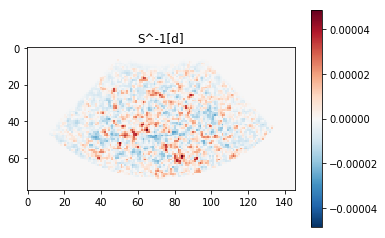

In [21]:
plotter(applySinv_fkp(density_grid),title='S^-1[d]')

### 4. Compute the usual (pseudo)-power spectra
As a first test, we'll compute the conventional window-convolved power spectra with PolyBin3D. 

To do this, we first load the power spectrum class with our choice of weighting and number density distribution. Note that we can optionally choose to include power spectra, $P_\ell(k)$, with odd $\ell$; these can be generated by wide-angle effects and mask convolution. We note that these are somewhat more difficult to compute in the unwindowed-estimator formalism as the Fisher matrix is slower to converge. However, excluding them from the calculation does *not* bias the estimation of $P_{\ell=\rm even}$, except at second-order in the small parameter $1/(kd)$, where $d$ is the distance to the sample.

After loading the class, we run the power spectrum estimator ```pspec.Pk_unwindowed()``` to compute the power spectra. Here, we'll use an idealized normalization scheme that does not correct for leakage between bins, since we want to compute *window-convolved* spectra. We'll also assume the classical normalization:
$$N_2 = \int d\vec x\,n(\vec x)n_z(\vec x)w_{\rm FKP}^2(\vec x).$$

In [23]:
# Define some k-bins and ell_max
k_edges = np.arange(0.0063,0.245,0.02)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, 
                 applySinv = applySinv_fkp, # S^-1 weighting function
                 mask = rand_grid, # pixel-window-deconvolved mask
                 lmax = lmax, # maximum multipole
                 odd_l=False) # whether to include odd multipoles 

# Define FKP normalization on the grid
pk_norm = np.sum(nz_grid*rand_grid*fkp_weight**2)/gridsize.prod()

# Compute the ideal normalization matrix (just encoding the bin volumes, and some discreteness effects)
fish_ideal = pk_norm*pspec.compute_fisher_ideal()

# Compute the *window-convolved* spectrum
Pk_fkp = pspec.Pk_unwindowed(density_grid, fish=fish_ideal, subtract_shotnoise=False)


Binning: 11 bins in [0.006, 0.226] h/Mpc
l-max: 4
Mask: spatially varying
Generating spherical harmonics


For comparison, we can compute the power spectrum using Nbodykit:

In [24]:
# Add an n_z column for the catalog (using our fiducial cosmology)
cat['nz'] = nz_interp(cat['Z'])
cat_rand['nz'] = nz_interp(cat_rand['Z'])

# Define FKP weights
cat['fkp_weight'] = 1./(P_fkp*cat['nz']+1.)
cat_rand['fkp_weight'] = 1./(P_fkp*cat_rand['nz']+1.)

# Recompute the density-field with the pixel-window-compensation and FKP weights applied, and shifting along the line-of-sight
cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
cat_fkp_nb['data/Position'] += boxcenter
cat_fkp_nb['randoms/Position'] += boxcenter
density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, interlaced=True, 
                               compensated=True,position='Position',
                               fkp_weight='fkp_weight', comp_weight='WEIGHT', resampler='tsc')

# Compute the Nbodykit power spectrum in the same bins
r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])

# Reshape output
Pk_nb = {'p0':r.poles['power_0'].real,'p2':r.poles['power_2'].real,'p4':r.poles['power_4'].real}

Let's compare the two! Below, we plot the power spectrum multipoles $P_{0,2,4}(k)$ in our $k$-bins. We find good agreement in general. Slight differences arise from (a) computing FKP weights on the grid instead of at the catalog level, (b) PolyBin3D accounting for discreteness effects in the Fourier-space grid (giving slightly more accurate estimation of low-$k$ modes with $\ell>0$), (c) defining the normalization on the grid instead of at the catalog level. 

All the above effects will be fully accounted for by the optimal estimators, which take the gridding and discreteness effects into account in both the numerator and normalization.

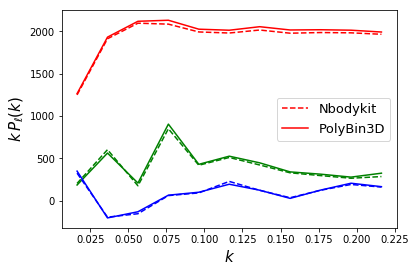

In [25]:
# Compute k 
k_cen = pspec.get_ks()

cs = {0:'r',1:'purple',2:'g',3:'orange',4:'blue'}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2,4]):
    plt.plot(k_cen, k_cen*Pk_nb['p%d'%l],c=cs[l],ls='--',label='Nbodykit')
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l],c=cs[l],ls='-',label='PolyBin3D')
    if li==0: plt.legend(fontsize=13)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5. Compute the "unwindowed" power spectra

Now we compute the main quantity of interest; window-deconvolved galaxy power spectrum measurements. For this, we first compute the Fisher matrix, $\mathcal{F}_{\alpha\beta}$ using Monte Carlo methods. This encodes the coupling between different modes induced by the local line-of-sight as well as mask-induced leakage, $\mathsf{S}^{-1}$ weighting and pixelation artefacts. This matrix is defined by requiring that the estimator returns an unbiased estimate of the power spectrum band-powers, given the mask and $\mathsf{S}^{-1}$ function.

The Fisher matrix can be expensive to compute, should usually be paralellized. Here, we use 10 realizations for testing (though more is usually useful in practice), computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method, which additionally allows for multi-processing. This additionally computes the Poissonian shot-noise term in the power spectrum estimator. Note that this does not depend on the data, so only has to be computed once!

In [26]:
# Number of Monte Carlo iterations
N_it = 10

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output, computing the mean of the quantities
fish = np.mean([f[0] for f in fish_and_shot],axis=0)
shot_num = np.mean([f[1] for f in fish_and_shot],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish, shot_num = pspec.compute_fisher(N_it, N_cpus=1, verb=True)

Computing iteration 1 of 10
Computing ideal Fisher matrix
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 10
Computing ideal Fisher matrix
Computing iteration 3 of 10
Computing ideal Fisher matrix
Computing iteration 4 of 10
Computing ideal Fisher matrix
Computing iteration 5 of 10
Computing ideal Fisher matrix
Computing iteration 6 of 10
Computing ideal Fisher matrix
Computing iteration 7 of 10
Computing ideal Fisher matrix
Computing iteration 8 of 10
Computing ideal Fisher matrix
Computing iteration 9 of 10
Computing ideal Fisher matrix
Computing iteration 10 of 10
Computing ideal Fisher matrix


Let's plot the matrix and compare it to the idealized form given above. These appear quite different; this is due to the mask- (and weighting-)induced leakage between $k$-bins and multipoles. We find significant leakage between adjacent power spectrum bins, and some minor leakage between higher-multipoles (the off-diagonal stripes in the correlation matrix). In contrast, the idealized Fisher matrix is almost diagonal (except for some small discreteness effects).

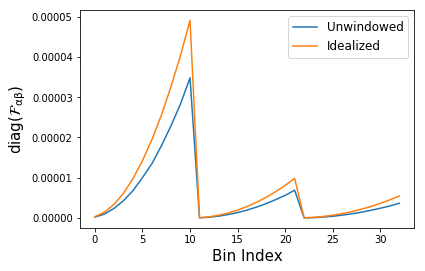

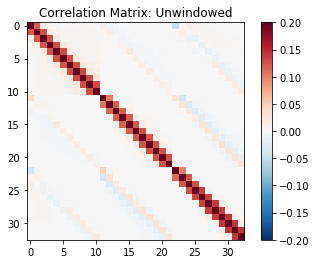

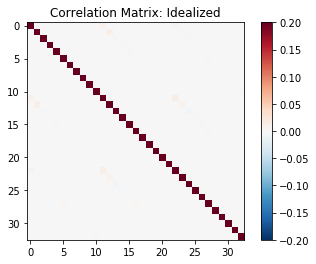

In [27]:
# Plot the diagonal
plt.plot(np.arange(len(fish)),np.diag(fish),label='Unwindowed')
plt.plot(np.diag(fish_ideal),label='Idealized')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\rm{diag}(\mathcal{F}_{\alpha\beta})$',fontsize=15);
plt.legend(fontsize=12);

# Plot the correlation structure
plot_corr(fish,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed')
plot_corr(fish_ideal,v=0.2,subtract_identity=False,title='Correlation Matrix: Idealized')

We now compute the power spectra, using the same routines as before, but feeding in our new Fisher matrix. We'll also consider varying the Fisher matrix to establish the impact of Monte Carlo noise in the Fisher matrix computation.

In [28]:
# Compute unwindowed power spectra
Pk_unwindowed = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Estimate Monte Carlo error by using two estimates of the Fisher matrix
fish1 = np.mean([f[0] for f in fish_and_shot[:N_it//2]],axis=0)
fish2 = np.mean([f[0] for f in fish_and_shot[N_it//2:]],axis=0)
Pk1 = pspec.Pk_unwindowed(density_grid, fish=fish1, shot_num=shot_num, subtract_shotnoise=False)
Pk2 = pspec.Pk_unwindowed(density_grid, fish=fish2, shot_num=shot_num, subtract_shotnoise=False)
Pk_err = {key: np.abs(Pk1[key]-Pk2[key]) for key in Pk_unwindowed}

Let's plot the power spectra below. We find a couple of important conclusions:
- Unwindowed power spectra are $\sim  10\%$ larger than the windowed equivalents. This reflects a known issue with the normalization of FKP spectra - the $N_2$ factor used in Nbodykit is a slight overestimate (which can be encapsulated by the window function). Here, we define the normalization completely in terms of the random catalog. 
- There is some residual uncertainty from the Monte Carlo computation of the Fisher matrix, particularly in the higher multipoles. This can be reduced by using more Monte Carlo realizations.
- The output spectra from PolyBin3D are (approximately) unwindowed *i.e.* they can be compared directly to theory, without need for window convolution. This assumes that the $k$-range given to PolyBin3D encompasses all relevant modes. For the highest $k$-modes in our estimator, we will miss contributions from modes at slightly higher $k$, thus these should generally be discarded (see e.g. the last monopole bin below). This can easily be ameliorated by measuring a larger range of $k$ than used in practice.

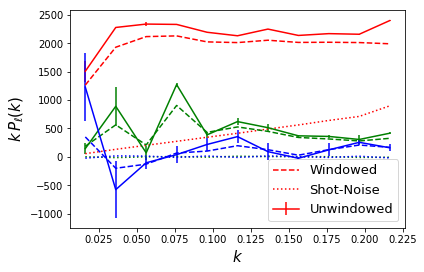

In [29]:
# Compute k 
k_cen = pspec.get_ks()

cs = {0:'r',1:'purple',2:'g',3:'orange',4:'blue'}

# Define shot-noise
Pk_shot = {'p%d'%l:pspec.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk] for l in [0,2,4]}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2,4]):
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*Pk_err['p%d'%l],
                 c=cs[l],ls='-',label='Unwindowed')
    plt.plot(k_cen, k_cen*Pk_fkp['p%d'%l],c=cs[l],ls='--',label='Windowed')
    plt.plot(k_cen, k_cen*Pk_shot['p%d'%l],c=cs[l],ls=':',label='Shot-Noise')
    if li==0: plt.legend(fontsize=13)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5a. Bonus #1: compute optimally-weighted spectra

Although the above spectra are window-deconvolved they are not quite optimal, due to the simplifying FKP-like $\mathsf{S}^{-1}$ assumed. In the below, we'll compute the spectra using the optimal $\mathsf{S}^{-1}$. Applied to a vector $u$ (which doesn't vanish with the mask), the inverse can be obtained by solving
$$[W\xi + \beta \mathsf{I}]\left(\mathsf{S}^{-1}u\right) = u$$
for $\mathsf{S}^{-1}u$ via conjugate gradient descent methods (where $\beta = 1$ ideally). Below, we implement this, computing the correlation function term in Fourier space, assuming a local line-of-sight.

## Need to define beta parameter!!

In [30]:
### First set up the matrix [W xi + beta I](x, y)

# Create a simple galaxy power spectrum, that we'll use for weighting
redshift = np.average(cat['Z'],weights=cat['WEIGHT'])
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)
beta = 1. # shot-noise rescaling

# Define fiducial power spectrum (assuming the Kaiser formula)
# Note that this does not include shot-noise!
k_arr = np.arange(0.0001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr

In [31]:
# Interpolate the spectra to a grid
Pkl_grid = {0:interp1d(k_arr, P0_arr, bounds_error=False, fill_value=0)(base.modk_grid),
            2:interp1d(k_arr, P2_arr, bounds_error=False, fill_value=0)(base.modk_grid),
            4:interp1d(k_arr, P4_arr, bounds_error=False, fill_value=0)(base.modk_grid)
           }

# Define spherical harmonics
Ylm_fourier = base._compute_real_harmonics(base.k_grids, pspec.lmax, odd_l=False)

# Function to apply the forward matrix
def apply_matrix(input_map):
    """Apply the matrix [W xi + beta I](x, y) to a map."""
    
    # Apply the power spectrum in Fourier-space (up to k_max)
    xi_dot_fourier = 0.+0.j
    for l in range(0,pspec.lmax+1,2):
        if l==0:
            leg_map = base.to_fourier(input_map)
        else:
            leg_map = np.sum([Ylm_fourier[l][lm_ind]*base.to_fourier(input_map*pspec.Ylm_real[l][lm_ind]) for lm_ind in range(len(Ylm_fourier[l]))],axis=0)
        xi_dot_fourier += leg_map*Pkl_grid[l]*(base.modk_grid<kmax)
    xi_dot_real = base.to_real(xi_dot_fourier).real
    
    # Apply the mask and Poisson noise
    output_map = pspec.mask*xi_dot_real + beta*input_map
    
    # Return output, killing pixels outside the range of interest
    return output_map*zero_grid

In [32]:
# CGD function
def cgd_inverse(input_map, applySinv_approx=applySinv_fkp, max_it=25, rel_tol=1e-3, verb=False):
    """Compute the conjugate gradient descent inverse solution for S^-1."""
    
    # Start timer
    start = time.time()
    
    # define initial guess for inverse and first term in sequence
    if verb: print("Computing initial guess")
    x = applySinv_approx(input_map)
    r = input_map - apply_matrix(x)
    p = applySinv_approx(r)
    C_p = apply_matrix(p)

    pre_r = applySinv_approx(r)
    old_sum = np.sum(r*pre_r)
    init_sum = old_sum.copy()
    alpha = old_sum/np.sum(p*C_p)
    save_sum = old_sum.copy()

    assert max_it < len(input_map.ravel())

    for i in range(max_it):
        if i>0 and verb: print("Starting iteration %d of %d: ratio = %.2e"%(i,max_it,np.sqrt(new_sum/init_sum)))
        
        if i%10==0 and i>0:
            # Check for stalling and stop if stalled
            if np.abs((save_sum-old_sum)/old_sum)<0.05:
                if verb: print("Inversion stalled after step %d; exiting (ratio %.2e/%.2e)"%(i+1,new_sum,init_sum))
                break
        
        # update x
        x = x+alpha*p
        # update r
        r = r-alpha*C_p
        # update S_approx^-1.r
        pre_r = applySinv_approx(r)
        # update sum(r * S_approx^-1.r)
        new_sum = np.sum(r*pre_r)
        # update p
        p = pre_r + (new_sum/old_sum)*p
        # Check for convergence
        if new_sum/init_sum<0:
            print("Bad sum on iteration %d (ratio %.2e/%.2e"%(i,new_sum,init_sum))
            break
        if np.sqrt(new_sum/init_sum)<rel_tol:
            if verb: print("Inversion stopped early after %d iterations (ratio %.2e/%.2e)"%(i+1,new_sum,init_sum))
            break
        
        # update sum
        old_sum = new_sum
        # update C.p
        C_p = apply_matrix(p)
        # compute alpha
        alpha = old_sum/np.sum(p*C_p)
    if i==max_it-1:
        if verb: print("CGD did not stop early: is this converged? (ratio %.2e/%.2e)"%(new_sum,init_sum))
    if verb:
        print("\nInversion took %.1f seconds"%(time.time()-start))
    return x

# Define the mean of the mask
mean_mask = np.average(nz_grid,weights=zero_grid)

# Define inverse Pk, *including* shot-noise piece
invPk0_grid = np.zeros_like(z_grid)
invPk0_grid[Pkl_grid[0]!=0] = 1./(Pkl_grid[0][Pkl_grid[0]!=0]+1./mean_mask)

# Define filtering
def applySinv_simplified(input_data, input_type='real', output_type='real'):
    """Apply a simplified filter to the data, assuming that both input and output maps are in real-space."""
   
    # Apply zero mask in real-space and divide by n(z)
    input_real = input_data*zero_grid/nz_grid
    
    # Transform to Fourier space and apply inverse monopole (including shot-noise)
    output_fourier = base.to_fourier(input_real)*invPk0_grid
    
    # Return output in real-space
    return base.to_real(output_fourier).real

Let's test this by applying the CGD to a pixel-window-deconvolved map. We find that the CGD has found the correct solution to moderate accuracy ($\sim 1\%$, as desired), though this usually requires quite a few number of Fourier transforms. The efficiency of the CGD inversion depends primarily on the choice of preconditioner, i.e. the approximate $\mathsf{S}^{-1}$ assumed to begin with. Above, we assume a simplified form, obtained by dividing the map by $n_z(\vec x)$, then filtering by the inverse power spectrum monopole in Fourier-space.

Computing initial guess
Starting iteration 1 of 25: ratio = 4.70e-01
Starting iteration 2 of 25: ratio = 2.04e-01
Starting iteration 3 of 25: ratio = 1.06e-01
Starting iteration 4 of 25: ratio = 5.36e-02
Starting iteration 5 of 25: ratio = 2.70e-02
Starting iteration 6 of 25: ratio = 1.44e-02
Inversion stopped early after 7 iterations (ratio 3.48e-07/5.75e-03)

Inversion took 8.2 seconds


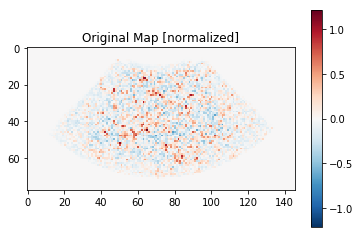

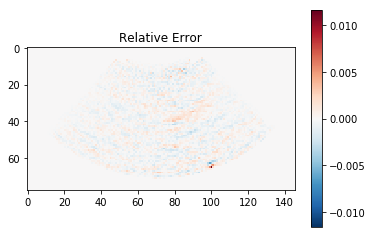

In [41]:
# Define input map
input_map = base.to_real(base.to_fourier(density_grid)/base.pixel_window_grid).real

# Apply CGD inverse
Sinv_map = cgd_inverse(input_map, applySinv_approx=applySinv_simplified, max_it=25, verb=True, rel_tol=1e-2)

# Plot, comparing [W xi + beta I].S^-1.x to the original map, x
plotter(input_map*zero_grid/np.average(pspec.mask,weights=zero_grid),title='Original Map [normalized]')
plotter((input_map*zero_grid-apply_matrix(Sinv_map))/np.average(pspec.mask,weights=zero_grid),title='Relative Error')

Now we can wrap the inverse in an $\mathsf{S}^{-1}$ function and proceed to compute the power spectrum and Fisher matrix! This will take quite a bit longer than before since each application of $\mathsf{S}^{-1}$ is quite expensive (and we have to compute it $N_{\rm bins}+1$ times), so we'll just use a few Monte Carlo realizations. Note that we can use a relatively poor error-tolerance on the CGD; as long as we use the same *approximate* form for $\mathsf{S}^{-1}$ everywhere, the estimator will be unbiased.

In [42]:
# Define filtering
def applySinv_optimal(input_data, input_type='real', output_type='real'):
    """Apply an optimal filter to the data, using conjugate gradient descent."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data).real
    else:
        input_real = input_data.copy().real
    
    # Apply FKP weight in real-space, using reduced error tolerance for testing
    output_real = cgd_inverse(input_real, max_it=25, rel_tol=1e-2, verb=False)
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

# Load the power spectrum class
pspec_opt = pb.PSpec(base, k_edges, 
                 applySinv = applySinv_optimal, # S^-1 weighting function
                 mask = rand_grid, # pixel-window-deconvolved mask
                 lmax = lmax, # maximum multipole
                 odd_l=False) # whether to include odd multipoles  


Binning: 11 bins in [0.006, 0.226] h/Mpc
l-max: 4
Mask: spatially varying
Generating spherical harmonics


In [35]:
# Number of Monte Carlo iterations
N_it = 10

# Iterate over realizations
fish_and_shot_opt = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot_opt.append(pspec_opt.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output, computing the mean of the quantities
fish_opt = np.mean([f[0] for f in fish_and_shot_opt],axis=0)
shot_num_opt = np.mean([f[1] for f in fish_and_shot_opt],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish_opt, shot_num_opt = pspec_opt.compute_fisher(N_it, N_cpus=1, verb=True)

Computing iteration 1 of 10
Computing ideal Fisher matrix
Generating GRF
Computing Q[S^-1.W.a] maps
CGD did not stop early: is this converged? (ratio 4.03e-11/1.94e-07)
Computing S^-1.W.Q[A^-1.a] maps
CGD did not stop early: is this converged? (ratio 4.33e-14/4.92e-08)
CGD did not stop early: is this converged? (ratio 5.81e-14/4.50e-08)
CGD did not stop early: is this converged? (ratio 1.61e-13/2.44e-08)
CGD did not stop early: is this converged? (ratio 3.96e-13/1.56e-08)
CGD did not stop early: is this converged? (ratio 7.47e-13/1.17e-08)
CGD did not stop early: is this converged? (ratio 1.52e-12/1.63e-08)
CGD did not stop early: is this converged? (ratio 2.64e-12/4.50e-08)
CGD did not stop early: is this converged? (ratio 4.61e-11/2.18e-07)
CGD did not stop early: is this converged? (ratio 1.02e-10/8.03e-07)
CGD did not stop early: is this converged? (ratio 2.47e-14/1.23e-08)
CGD did not stop early: is this converged? (ratio 2.26e-14/1.27e-08)
CGD did not stop early: is this converge

KeyboardInterrupt: 

In [44]:
# Number of Monte Carlo iterations
N_it = 4

# Zero counters
base.n_FFTs_forward = 0
base.n_FFTs_reverse = 0

# Iterate over realizations
fish_and_shot_opt = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot_opt.append(pspec_opt.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output, computing the mean of the quantities
fish_opt = np.mean([f[0] for f in fish_and_shot_opt],axis=0)
shot_num_opt = np.mean([f[1] for f in fish_and_shot_opt],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish_opt, shot_num_opt = pspec_opt.compute_fisher(N_it, N_cpus=1, verb=True)

Computing iteration 1 of 4
Computing ideal Fisher matrix
Generating GRF
Computing Q[S^-1.W.a] maps
CGD did not stop early: is this converged? (ratio 4.03e-11/1.94e-07)
Computing S^-1.W.Q[A^-1.a] maps
CGD did not stop early: is this converged? (ratio 1.52e-12/1.63e-08)
CGD did not stop early: is this converged? (ratio 4.61e-11/2.18e-07)
CGD did not stop early: is this converged? (ratio 1.02e-10/8.03e-07)
CGD did not stop early: is this converged? (ratio 8.37e-13/7.44e-09)
CGD did not stop early: is this converged? (ratio 8.02e-13/7.43e-09)
CGD did not stop early: is this converged? (ratio 9.60e-12/4.19e-08)
CGD did not stop early: is this converged? (ratio 8.14e-12/4.10e-08)
CGD did not stop early: is this converged? (ratio 2.99e-11/1.65e-07)
CGD did not stop early: is this converged? (ratio 3.80e-11/1.61e-07)
CGD did not stop early: is this converged? (ratio 2.23e-13/1.94e-09)
CGD did not stop early: is this converged? (ratio 1.56e-13/1.91e-09)
CGD did not stop early: is this converged

In [45]:
# Compute unwindowed power spectra
Pk_unwindowed_opt = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt, shot_num=shot_num_opt, subtract_shotnoise=False)

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Estimate Monte Carlo error by using two estimates of the Fisher matrix
fish_opt1 = np.mean([f[0] for f in fish_and_shot_opt[:N_it//2]],axis=0)
fish_opt2 = np.mean([f[0] for f in fish_and_shot_opt[N_it//2:]],axis=0)
Pk_opt1 = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt1, shot_num=shot_num_opt, subtract_shotnoise=False)
Pk_opt2 = pspec_opt.Pk_unwindowed(density_grid, fish=fish_opt2, shot_num=shot_num_opt, subtract_shotnoise=False)
Pk_opt_err = {key: np.abs(Pk_opt1[key]-Pk_opt2[key]) for key in Pk_unwindowed_opt}

CGD did not stop early: is this converged? (ratio 4.61e-06/1.44e-02)
CGD did not stop early: is this converged? (ratio 4.61e-06/1.44e-02)
CGD did not stop early: is this converged? (ratio 4.61e-06/1.44e-02)


### Let's make some plots

### also note that there's different residual leakage in the different estimators! and different noise!

### comment on how CGD inverse gives rough covariance of data too?

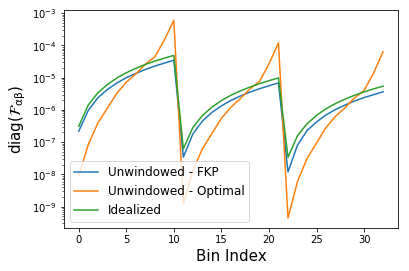

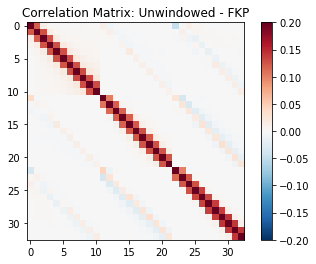

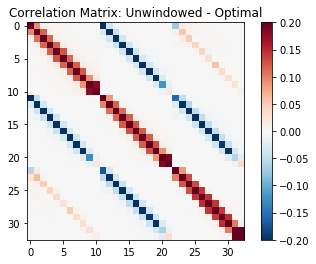

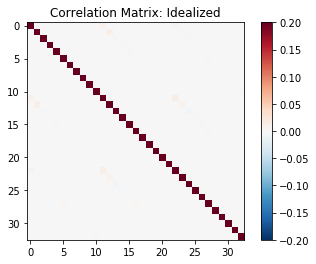

In [59]:
# Plot the diagonal
plt.plot(np.arange(len(fish)),np.diag(fish),label='Unwindowed - FKP')
plt.plot(np.arange(len(fish)),np.diag(fish_opt),label='Unwindowed - Optimal')
plt.plot(np.diag(fish_ideal),label='Idealized')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$\rm{diag}(\mathcal{F}_{\alpha\beta})$',fontsize=15);
plt.legend(fontsize=12);
plt.yscale('log');

# Plot the correlation structure
plot_corr(fish,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed - FKP')
plot_corr(fish_opt,v=0.2,subtract_identity=False,title='Correlation Matrix: Unwindowed - Optimal')
plot_corr(fish_ideal,v=0.2,subtract_identity=False,title='Correlation Matrix: Idealized')

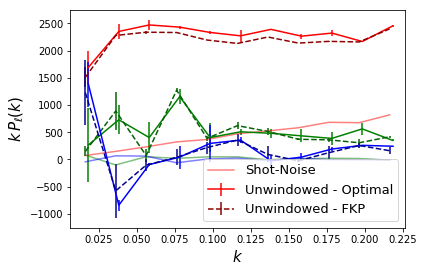

In [55]:
# Compute k 
k_cen = pspec_opt.get_ks()
dk = k_cen[1]-k_cen[0]

cs = {0:'r',2:'g',4:'blue'}
cs2 = {0:'darkred',2:'darkgreen',4:'darkblue'}

# Define shot-noise
Pk_shot = {'p%d'%l:pspec_opt.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk] for l in [0,2,4]}

# Plot spectra
plt.figure()
for li,l in enumerate([0,2,4]):
    plt.errorbar(k_cen+dk/10, k_cen*Pk_unwindowed_opt['p%d'%l],yerr=k_cen*Pk_opt_err['p%d'%l],
                 c=cs[l],ls='-',label='Unwindowed - Optimal')
    plt.errorbar(k_cen, k_cen*Pk_unwindowed['p%d'%l],yerr=k_cen*Pk_err['p%d'%l],
                 c=cs[l],ls='--',label='Unwindowed - FKP')
    plt.plot(k_cen, k_cen*Pk_shot['p%d'%l],c=cs[l],ls='-',label='Shot-Noise',alpha=0.5)
    if li==0: plt.legend(fontsize=13)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
dk = k_cen[1]-k_cen[0]
plt.xlim(k_cen[0]-dk/2,k_cen[-1]+dk/2);

### 5b. Bonus #2: compute rectangular binning matrices.

## TODO: add shot-noise $\beta$ 
## add bin convolution matrix!

### Older: use the older routine!!

In [175]:
def compute_theory_matrix(self, seed, k_bins_theory, applySinv_transpose=None, verb=False):
    """This computes the a rectangular matrix used to window-convolve the theory, using a single GRF simulation, created internally.
    
    We must specify the desired theory binning. An optional input is a function that applies S^-T to a map. The code will assume S^-T = S^-1 if this is not supplied."""

    if self.applySinv==None:
        raise Exception("Must supply S^-1 function to compute unwindowed estimators!")

    if type(applySinv_transpose)!=type(lambda x: x):
        print(type(applySinv_transpose))
        applySinv_transpose = self.applySinv
        print("## Caution: assuming S^-1 is symmetric!")

    assert np.max(k_bins_theory)<np.min(base.kNy), "k_max must be less than k_Nyquist!"
    assert np.min(k_bins_theory)>=np.max(base.kF), "k_min must be at least the k_fundamental!"
    assert np.max(k_bins_theory)<=base.Pfid[0][-1], "Fiducial power spectrum should extend up to k_max!"
    assert np.min(k_bins_theory)>=base.Pfid[0][0], "Fiducial power spectrum should extend down to k_min!"
    if np.max(k_bins_theory)>np.min(base.kNy)/2:
        print("## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.")
    
    # Initialize output
    Nk_th = len(k_bins_theory)-1
    N_bins_th = self.Nl*Nk_th
    fish = np.zeros((self.N_bins,N_bins_th))

    # Compute a random realization with known power spectrum
    if verb: print("Generating GRF")
    a_map_fourier = self.base.generate_data(seed=seed+int(1e7), output_type='fourier')
    if not self.const_mask:
        a_map_real = self.base.to_real(a_map_fourier)
        
    # Define spherical harmonics
    Ylm_fourier = self.base._compute_real_harmonics(self.base.k_grids, self.lmax, self.odd_l)
    
    # Define Q map code
    def compute_Q_Sinv():
        """
        Assemble and return the Q [ = partial_l,b . xi . S^-1 W . a] maps in Fourier-space.

        The outputs is W^TS^-T Q(l,b).
        """
        
        # Define k filter
        filt = lambda ki: (self.base.modk_grid>=self.k_bins[ki])*(self.base.modk_grid<self.k_bins[ki+1])
        
        # Compute S^-1 W a
        if self.const_mask:
            weighted_map_fourier = self.applySinv(a_map_fourier, input_type='fourier', output_type='fourier')*self.mask_mean
        else:
            weighted_map_fourier = self.applySinv(self.mask*a_map_real, input_type='real', output_type='fourier')
    
        # Define real-space map (where necessary)
        if self.base.sightline=='local' and self.lmax>0:
            weighted_map_real = self.base.to_real(weighted_map_fourier)
        
        # Define arrays
        Q_maps = np.zeros((self.N_bins,self.base.gridsize.prod()),dtype='complex')
        
        def _apply_weighting(input_map, real=False):
            """Apply W^T S^-T weighting to maps. Input is either a Fourier-space map or a real-space map."""
            if self.const_mask:
                if real:
                    return self.mask_mean*applySinv_transpose(input_map,input_type='real',output_type='fourier')
                else:
                    return self.mask_mean*applySinv_transpose(input_map,input_type='fourier',output_type='fourier')         
            else:
                if real:
                    # Use real-space map directly
                    return self.base.to_fourier(self.mask*applySinv_transpose(input_map,input_type='real',output_type='real'))
                else:
                    return self.base.to_fourier(self.mask*applySinv_transpose(input_map,input_type='fourier',output_type='real'))
        
        # Compute Q derivative for the monopole
        for ki in range(self.Nk):
            Q_maps[ki,:] = _apply_weighting(weighted_map_fourier*filt(ki), real=False).ravel()

        # Repeat for higher-order multipoles
        for li in range(1,self.Nl):

            if self.base.sightline=='global':
                # Compute L_ell(mu)* S^-1 W a
                leg_map = weighted_map_fourier*legendre(li*2)(self.muk_grid)

                # Add to bins
                for ki in range(self.Nk):
                    Q_maps[li*self.Nk+ki,:] = _apply_weighting(leg_map*filt(ki), real=False).ravel()                           

            else:
                # First part: (-1)^l Theta_b(k) Sum_m Y_lm(k)* [U^-1 a]_lm(k)
                leg_map = np.sum([Ylm_fourier[(2-self.odd_l)*li][lm_ind]*self.base.to_fourier(weighted_map_real*self.Ylm_real[(2-self.odd_l)*li][lm_ind]) for lm_ind in range(len(self.Ylm_real[(2-self.odd_l)*li]))],axis=0)

                # Add phase for odd ell
                if (self.odd_l and li%2==1):
                    leg_map *= -1

                # Add to bins
                for ki in range(self.Nk):
                    
                    # Add first part
                    Q_maps[li*self.Nk+ki,:] += 0.5*_apply_weighting(leg_map*filt(ki), real=False).ravel()

                    # Second part: Sum_m Y_lm (x) Int_k e^ik.x Theta_b(k) Y_lm(k)*[S^-1 W a](k)                        
                    real_map = np.zeros(self.base.gridsize,dtype='complex')
                    for lm_ind in range(len(self.Ylm_real[(2-self.odd_l)*li])):
                        # Cast to full Fourier-space map
                        k_map = weighted_map_fourier*Ylm_fourier[(2-self.odd_l)*li][lm_ind]*filt(ki)
                        real_map += self.base.to_real(k_map)*self.Ylm_real[(2-self.odd_l)*li][lm_ind]

                    # Add second part, using the real-space map [which fills all Fourier modes, not just those in [k_min, k_max]]
                    Q_maps[li*self.Nk+ki,:] += 0.5*_apply_weighting(real_map, real=True).ravel()

                    # Add 1.0j to imaginary parts to keep maps real
                    if (self.odd_l and li%2==1):
                        Q_maps[li*self.Nk+ki] *= 1.0j

        return Q_maps    

    def compute_Q_Ainv():
        """
        Assemble and return the Q [ = partial_l,b . xi . weighting . a] maps in Fourier-space.
        """
        
        # Define k filter
        filt = lambda ki: (self.base.modk_grid>=k_bins_theory[ki])*(self.base.modk_grid<k_bins_theory[ki+1])
        
        # Compute A^-1 a
        weighted_map_fourier = self.base.applyAinv(a_map_fourier, input_type='fourier', output_type='fourier')

        # Define real-space map (where necessary), and drop Fourier-modes out of range
        if self.base.sightline=='local' and self.lmax>0:
            weighted_map_real = self.base.to_real(weighted_map_fourier)
        
        # Define arrays
        Q_maps = np.zeros((N_bins_th,self.base.gridsize.prod()),dtype='complex')

        # Compute Q derivative for the monopole, optionally adding S^-1.W weighting
        for ki in range(Nk_th):
            Q_maps[ki,:] = (weighted_map_fourier*filt(ki)).ravel()
  
        # Repeat for higher-order multipoles
        for li in range(1,self.Nl):

            if self.base.sightline=='global':
                # Compute L_ell(mu)* A-1 a
                leg_map = weighted_map_fourier*legendre(li*2)(self.muk_grid)

                # Add to bins
                for ki in range(Nk_th):
                    Q_maps[li*Nk_th+ki,:] = (leg_map*filt(ki)).ravel()                           
    
            else:
                
                # First part: (-1)^l Theta_b(k) Sum_m Y_lm(k)* [U^-1 a]_lm(k)
                leg_map = np.sum([Ylm_fourier[(2-self.odd_l)*li][lm_ind]*self.base.to_fourier(weighted_map_real*self.Ylm_real[(2-self.odd_l)*li][lm_ind]) for lm_ind in range(len(self.Ylm_real[(2-self.odd_l)*li]))],axis=0)

                # Add phase for odd ell
                if (self.odd_l and li%2==1):
                    leg_map *= -1

                # Add to bins
                for ki in range(Nk_th):
                    
                    # Add first part, absorbing second by symmetry
                    Q_maps[li*Nk_th+ki,:] += (leg_map*filt(ki)).ravel()
                    
                    # Add 1.0j to imaginary parts to keep maps real
                    if (self.odd_l and li%2==1):
                        Q_maps[li*Nk_th+ki] *= 1.0j

        
        return Q_maps    
                                                    
    if verb: print("Computing W^T.S^-T.Q[S^-1.W.a] maps")
    Q_Sinv = compute_Q_Sinv()

    if verb: print("Computing Q[A^-1.a] maps")
    Q_Ainv = compute_Q_Ainv()

    # Assemble Fisher matrix
    if verb: print("Assembling Fisher matrix\n")

    # Compute binning matrix as an outer product
    binning_matrix = 0.5*np.real(np.matmul(Q_Sinv.conj(),Q_Ainv.T))*self.base.volume/self.base.gridsize.prod()**2

    return binning_matrix


### below is slower (but less memory intensive)...

In [176]:
# def compute_theory_matrix(self, seed, k_bins_theory, applySinv_transpose=None, verb=False):
#     """This computes the a rectangular matrix used to window-convolve the theory, using a single GRF simulation, created internally.
    
#     We must specify the desired theory binning. An optional input is a function that applies S^-T to a map. The code will assume S^-T = S^-1 if this is not supplied."""

#     if self.applySinv==None:
#         raise Exception("Must supply S^-1 function to compute unwindowed estimators!")

#     if type(applySinv_transpose)!=type(lambda x: x):
#         print(type(applySinv_transpose))
#         applySinv_transpose = self.applySinv
#         print("## Caution: assuming S^-1 is symmetric!")

#     assert np.max(k_bins_theory)<np.min(base.kNy), "k_max must be less than k_Nyquist!"
#     assert np.min(k_bins_theory)>=np.max(base.kF), "k_min must be at least the k_fundamental!"
#     assert np.max(k_bins_theory)<=base.Pfid[0][-1], "Fiducial power spectrum should extend up to k_max!"
#     assert np.min(k_bins_theory)>=base.Pfid[0][0], "Fiducial power spectrum should extend down to k_min!"
    
#     # Initialize output
#     Nk_th = len(k_bins_theory)-1
#     N_bins_th = self.Nl*Nk_th
#     binning = np.zeros((self.N_bins,N_bins_th))

#     # Compute a random realization with known power spectrum
#     if verb: print("Generating GRF")
#     a_map_fourier = self.base.generate_data(seed=seed+int(1e7), output_type='fourier')
#     if not self.const_mask:
#         a_map_real = self.base.to_real(a_map_fourier)
        
#     # Define k filters
#     filt = lambda ki: (self.base.modk_grid>=self.k_bins[ki])*(self.base.modk_grid<self.k_bins[ki+1])
#     filt_ths = np.asarray([(self.base.modk_grid.ravel()>=k_bins_theory[ki])*(self.base.modk_grid.ravel()<k_bins_theory[ki+1]) for ki in range(len(k_bins_theory)-1)])
        
#     # Define spherical harmonics
#     if verb: print("Computing spherical harmonics")
#     if self.base.sightline=='local': 
#         Ylm_fourier = self.base._compute_real_harmonics(self.base.k_grids, self.lmax, self.odd_l)
        
#     # Compute S^-1 W a
#     if verb: print("Weighting maps")
#     if self.const_mask:
#         Sinv_map_fourier = self.applySinv(a_map_fourier, input_type='fourier', output_type='fourier')*self.mask_mean
#     else:
#         Sinv_map_fourier = self.applySinv(self.mask*a_map_real, input_type='real', output_type='fourier')

#     # Compute A^-1 a
#     Ainv_map_fourier = self.base.applyAinv(a_map_fourier, input_type='fourier', output_type='fourier')

#     # Define real-space maps (where necessary)
#     if self.base.sightline=='local' and self.lmax>0:
#         Sinv_map_real = self.base.to_real(Sinv_map_fourier)
#         Ainv_map_real = self.base.to_real(Ainv_map_fourier)
#     Ainv_map_fourier = Ainv_map_fourier.ravel()
    
#     # Compute all necessary L_ell(mu) A^-1 maps
#     if self.lmax>0:
        
#         Ainv_leg_maps = {}
#         for li in range(1,self.Nl):
#             if self.base.sightline=='global':
#                 Ainv_leg_maps[li] = Ainv_map_fourier*legendre(li*2)(self.muk_grid)
#             elif self.base.sightline=='local':
#                 Ainv_leg_maps[li] = np.sum([Ylm_fourier[(2-self.odd_l)*li][lm_ind]*self.base.to_fourier(Ainv_map_real*self.Ylm_real[(2-self.odd_l)*li][lm_ind]) for lm_ind in range(len(self.Ylm_real[(2-self.odd_l)*li]))],axis=0).ravel()

#     def _apply_weighting(input_map, real=False):
#         """Apply W^T S^-T weighting to maps. Input is either a Fourier-space map or a real-space map."""
#         if self.const_mask:
#             if real:
#                 return self.mask_mean*applySinv_transpose(input_map,input_type='real',output_type='fourier')
#             else:
#                 return self.mask_mean*applySinv_transpose(input_map,input_type='fourier',output_type='fourier')         
#         else:
#             if real:
#                 # Use real-space map directly
#                 return self.base.to_fourier(self.mask*applySinv_transpose(input_map,input_type='real',output_type='real'))
#             else:
#                 return self.base.to_fourier(self.mask*applySinv_transpose(input_map,input_type='fourier',output_type='real'))

#     def _compute_row(Sinv_map, real=False):
#         """Compute row of the binning matrix, using all theory bins for a given estimator bin."""
        
#         # Define output
#         binning_row = np.zeros(N_bins_th)
        
#         # Apply weighting to input map
#         t1 = time.time()
#         fourier_map = _apply_weighting(Sinv_map, real=real).conj().ravel()
#         t2 = time.time()
#         print(t2-t1)
        
#         # Process monopole
#         fourier_Ainv = fourier_map*Ainv_map_fourier
#         binning_row[:Nk_th] = 0.5*np.sum(fourier_Ainv*filt_ths,axis=1).real  
#         t3 = time.time()
#         print(t3-t2)
#         del fourier_Ainv
                            
#         # Repeat for higher-order multipoles
#         for li in range(1,self.Nl):
                            
#             fourier_leg_Ainv = fourier_map*Ainv_leg_maps[li]
            
#             # Add 1.0j to imaginary parts to keep maps real
#             if (self.odd_l and li%2==1):
#                 fourier_leg_Ainv *= -1.0j
                            
#             binning_row[li*Nk_th:(li+1)*Nk_th] = 0.5*np.sum(fourier_leg_Ainv*filt_ths,axis=1).real   
#         print(time.time()-t3)
        
#         return binning_row
                
#     # Iterate over S^-1 axis
#     for ki in range(self.Nk):
#         print("l = 0, k-bin %d"%(ki+1))
#         binning[ki,:] = _compute_row(Sinv_map_fourier*filt(ki), real=False)

#     # Repeat for higher-order multipoles
#     for li in range(1,self.Nl):

#         if self.base.sightline=='global':
#             # Compute L_ell(mu)* S^-1 W a
#             leg_map = Sinv_map_fourier*legendre(li*2)(self.muk_grid)

#             # Add to bins
#             for ki in range(self.Nk):
                
#                 print("l = %d, k-bin %d"%((2-self.odd_l)*li,ki+1))
        
#                 binning[li*self.Nk+ki,:] = _compute_row(leg_map*filt(ki), real=False)                      

#         else:
#             # First part: (-1)^l Theta_b(k) Sum_m Y_lm(k)* [U^-1 a]_lm(k)
#             leg_map = np.sum([Ylm_fourier[(2-self.odd_l)*li][lm_ind]*self.base.to_fourier(Sinv_map_real*self.Ylm_real[(2-self.odd_l)*li][lm_ind]) for lm_ind in range(len(self.Ylm_real[(2-self.odd_l)*li]))],axis=0)

#             # Add phase for odd ell
#             if (self.odd_l and li%2==1):
#                 leg_map *= -1

#             # Add to bins
#             for ki in range(self.Nk):
                  
#                 print("l = %d, k-bin %d"%((2-self.odd_l)*li,ki+1))
        
#                 # Add 1.0j to imaginary parts to keep maps real
#                 if (self.odd_l and li%2==1):
#                     phase = 1.0j
#                 else:
#                     phase = 1.

#                 # Add first part
#                 binning[li*self.Nk+ki,:] += 0.5*_compute_row(leg_map*filt(ki)*phase, real=False)

#                 # Second part: Sum_m Y_lm (x) Int_k e^ik.x Theta_b(k) Y_lm(k)*[S^-1 W a](k)                        
#                 real_map = np.zeros(self.base.gridsize,dtype='complex')
#                 for lm_ind in range(len(self.Ylm_real[(2-self.odd_l)*li])):
#                     # Cast to full Fourier-space map
#                     k_map = Sinv_map_fourier*Ylm_fourier[(2-self.odd_l)*li][lm_ind]*filt(ki)
#                     real_map += self.base.to_real(k_map)*self.Ylm_real[(2-self.odd_l)*li][lm_ind]

#                 # Add second part, using the real-space map [which fills all Fourier modes, not just those in [k_min, k_max]]
#                 binning[li*self.Nk+ki,:] += 0.5*_compute_row(real_map*phase, real=True)

#     return binning


In [177]:
#k_edges_th = k_edges.copy()#
k_edges_th = np.arange(0.007,0.240,0.01)

In [178]:
print(len(k_edges_th)-1,len(k_edges)-1)

(23, 11)


In [179]:
ths = []
fishs = []
for i in range(5):
    th_matrix = compute_theory_matrix(pspec, i, k_edges_th, applySinv_fkp, verb=True)
    ths.append(th_matrix)
    f = pspec.compute_fisher_contribution(i, verb=True)[0]
    fishs.append(f)

## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Generating GRF
Computing W^T.S^-T.Q[S^-1.W.a] maps
Computing Q[A^-1.a] maps
Assembling Fisher matrix

Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Generating GRF
Computing W^T.S^-T.Q[S^-1.W.a] maps
Computing Q[A^-1.a] maps
Assembling Fisher matrix

Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Generating GRF
Computing W^T.S^-T.Q[S^-1.W.a] maps
Computing Q[A^-1.a] maps
Assembling Fisher matrix

Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Generating GRF
Compu

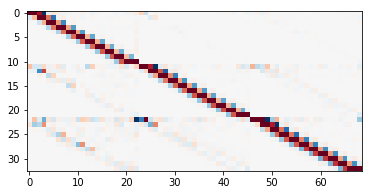

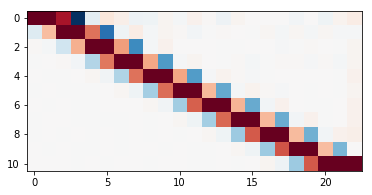

In [185]:
fish = np.mean(fishs,axis=0)
th_matrix = np.mean(ths, axis=0)
k_cen_th = 0.5*(k_edges_th[1:]+k_edges_th[:-1])

cth_matrix = np.matmul(np.linalg.inv(fish),th_matrix)

plt.imshow(cth_matrix,vmax=0.1,vmin=-0.1,cmap=cm.RdBu_r)

plt.figure()
plt.imshow(cth_matrix[:pspec.Nk,:len(k_cen_th)],vmax=0.1,vmin=-0.1,cmap=cm.RdBu_r)

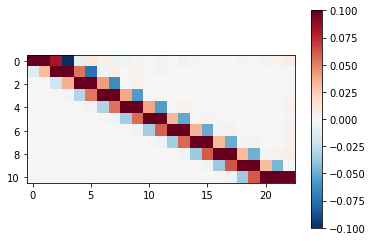

In [183]:
plt.imshow(np.matmul(np.linalg.inv(fish),th_matrix)[:len(k_cen),:len(k_cen_th)],
          cmap=cm.RdBu_r,vmax=0.1,vmin=-0.1);
plt.colorbar();

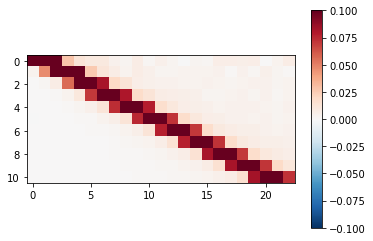

In [189]:
plt.imshow(np.matmul(np.linalg.inv(fish_ideal),th_matrix)[:len(k_cen),:len(k_cen_th)],
          cmap=cm.RdBu_r,vmax=0.1,vmin=-0.1);
plt.colorbar();

### this is quite cool: almost all of the leakage has disappeared!

## merge into main code? maybe also divide by fish by default?

### check the apply_matrix routine!!

### need to figure out this zero-filt thing!? The above killed modes with z outside range but this misses radial information??

### check other forms of preconditioner - are these better?

In [346]:
# Define fiducial power spectrum (assuming the Kaiser formula)
# Using a better estimate of P(k) would result in a slightly more optimal estimator

cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# Create a simple galaxy power spectrum
redshift = 0.55
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
nbar = 3e-4
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.0001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

In [ ]:
k_cen_th = 0.5*(k_edges_th[1:]+k_edges_th[:-1])
p_th = np.concatenate([interp1d(k_arr,P0_arr)(k_cen_th),
                       interp1d(k_arr,P2_arr)(k_cen_th),
                       interp1d(k_arr,P4_arr)(k_cen_th)])
p_raw = np.concatenate([interp1d(k_arr,P0_arr)(k_cen),
                        interp1d(k_arr,P2_arr)(k_cen),
                        interp1d(k_arr,P4_arr)(k_cen)])
p_conv = np.matmul(cth_matrix,p_th)

In [ ]:
plt.plot(k_cen_th,k_cen_th*p_th[:len(k_cen_th)],marker='.')
plt.plot(k_cen,k_cen*p_raw[:pspec.Nk],marker='x')

In [ ]:
cs = ['r','b','g']
for i in [0,1]:
    plt.plot(k_cen,k_cen*p_raw[i*pspec.Nk:(i+1)*pspec.Nk],ls='-',marker='x',c=cs[i])
    plt.plot(k_cen,k_cen*p_conv[i*pspec.Nk:(i+1)*pspec.Nk],ls='--',marker='.',c=cs[i])

## the above doesn't *quite* agree!!

## fish doesn't quite agree with the matrix. Can we fix this?
### also not sure how this works for odd multipoles

### to test above!!!

### BOSS Mask, known data

In [4]:
# Define fiducial power spectrum (assuming the Kaiser formula)
# Using a better estimate of P(k) would result in a slightly more optimal estimator

cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# Create a simple galaxy power spectrum
redshift = 0.55
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
nbar = 3e-4
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.0001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

KeyboardInterrupt: 

In [ ]:
gridsize = [78,146,82]
boxsize = [1.01e+03, 1.91e+03, 1.06e+03]
mask_grid_file = 'lowz_south_mask_grid(%d,%d,%d).npy'%(gridsize[0],gridsize[1],gridsize[2])

# Load already precomputed mask if it exists!
if os.path.exists(mask_grid_file):
    print("Loadng precomputed mask")
    mask_grid = np.load(mask_grid_file)

In [948]:
#input_mask = nbar*np.ones_like(mask_grid)
#+np.random.randn(*gridsize)*nbar*1e-6
input_mask = mask_grid

### no pixel window!!

In [949]:
# Load the PolyBin3D class
import PolyBin3D as pb
base = PolyBin3D(boxsize, gridsize, [k_arr,P0_arr],#**2],#Pk_fiducial, 
                 boxcenter=np.asarray([7.32e+02, 1.49e+01, 2.31e+02]), # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 #pixel_window='none', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )


# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [7.32e+02, 1.49e+01, 2.31e+02] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [78, 146, 82]
# Fundamental frequency: [0.006, 0.003, 0.006] h/Mpc
# Nyquist frequency: [0.243, 0.240, 0.243] h/Mpc
# Pixel window: interlaced-tsc


In [950]:
beta = 1
P_fkp = 1e4

fkp_weight = 1./(input_mask*P_fkp+beta)

def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply an FKP-like filter to the data."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply FKP weight
    output_real = input_real*fkp_weight
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

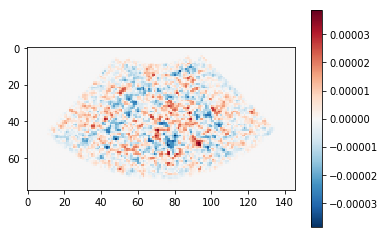

In [951]:
plotter(applySinv_fkp(density_grf))

### reducing binning

### removing odd ell!!

In [1131]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.20,0.02)
lmax = 2

# Load the power spectrum class
pspec = PSpec(base, k_edges, applySinv = applySinv_fkp, mask = input_mask, lmax = lmax, odd_l=False)

# Define the k-bin centers
k_cen = pspec.get_ks()


## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Binning: 9 bins in [0.010, 0.190] h/Mpc
l-max: 2
Mask: spatially varying
Generating spherical harmonics


In [309]:
#if np.std(input_mask)>1e-10:

# Number of Monte Carlo iterations
N_it = 10

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))

# Clean-up output
fish1 = np.mean([f[0] for f in fish_and_shot[:5]],axis=0)
fish2 = np.mean([f[0] for f in fish_and_shot[5:]],axis=0)
fish = 0.5*(fish1+fish2)
shot = np.mean([f[1] for f in fish_and_shot],axis=0)

#fish, shot = pspec.compute_fisher(10, 1, False)

Computing iteration 1 of 10
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 10
Computing iteration 3 of 10
Computing iteration 4 of 10
Computing iteration 5 of 10
Computing iteration 6 of 10
Computing iteration 7 of 10
Computing iteration 8 of 10
Computing iteration 9 of 10
Computing iteration 10 of 10


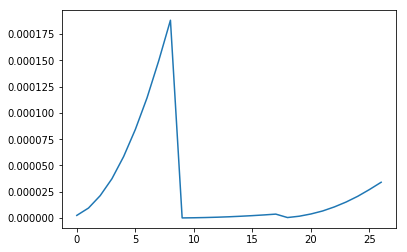

In [310]:
plt.plot(np.diag(fish))

### filtering out bad k!

In [311]:
N_sim = 10

bin_filt = (k_arr>=k_edges[0])*(k_arr<k_edges[-1])

if np.std(input_mask)<1e-10:
    tPkis = []
    tPks = []
    for sim in range(N_sim):
        if sim%10==0: print("Iteration %d of %d"%(sim+1,N_sim))

        # Generate GRF
        density_grf = base.generate_data(sim, Pk_input=[k_arr,P0_arr*bin_filt])#,P2_arr*bin_filt])#,P4_arr*bin_filt])

        # Apply mask before pixellation
        density_grf = base.to_real(base.pixel_window_grid*base.to_fourier(input_mask*base.to_real(base.to_fourier(density_grf)/base.pixel_window_grid)))
        #density_grf = input_mask*density_grf

        tPkis.append(pspec.Pk_ideal(density_grf))
        tPks.append(pspec.Pk_unwindowed(density_grf,fish,shot,subtract_shotnoise=False))
    tshot = np.matmul(np.linalg.inv(fish),shot).copy()

else:
    fPkis = []
    fPks = []
    fPksA = []
    fPksB = []
    for sim in range(N_sim):
        if sim%10==0: print("Iteration %d of %d"%(sim+1,N_sim))

        # Generate GRF
        density_grf = base.generate_data(sim, Pk_input=[k_arr,P0_arr*bin_filt])#,P2_arr*bin_filt])#,P4_arr*bin_filt])

        # Apply mask before pixellation
        density_grf = base.to_real(base.pixel_window_grid*base.to_fourier(input_mask*base.to_real(base.to_fourier(density_grf)/base.pixel_window_grid)))
        #density_grf = input_mask*density_grf

        fPkis.append(pspec.Pk_ideal(density_grf))
        fPks.append(pspec.Pk_unwindowed(density_grf, fish=fish, shot_num=shot, subtract_shotnoise=False))
        fPksA.append(pspec.Pk_unwindowed(density_grf, fish=fish1, shot_num=shot, subtract_shotnoise=False))
        fPksB.append(pspec.Pk_unwindowed(density_grf, fish=fish2, shot_num=shot, subtract_shotnoise=False))
        
    fshot = np.matmul(np.linalg.inv(fish),shot).copy()

Iteration 1 of 10
Computing ideal Fisher matrix


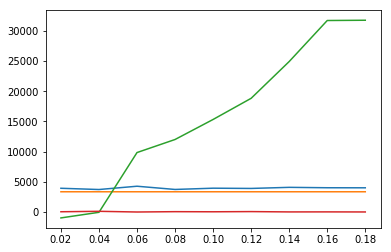

In [312]:
plt.plot(k_cen,fshot[0*pspec.Nk:1*pspec.Nk])
plt.plot(k_cen,tshot[0*pspec.Nk:1*pspec.Nk])
plt.plot(k_cen,fshot[pspec.Nk:2*pspec.Nk])
plt.plot(k_cen,tshot[pspec.Nk:2*pspec.Nk])

Text(0,0.5,'$k\\,P_\\ell(k)$')

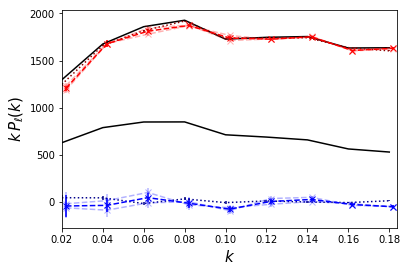

In [315]:
cs = ['r','y','b','orange','g']
c2s = ['darkred','y','darkblue','orange','g']

for l in [0,2]:
#     if l%2==0:
#         plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPkis],axis=0),
#                 yerr=k_cen*np.std([P['p%d'%l] for P in tPkis],axis=0)/np.sqrt(N_sim),
#             ls='-',marker='',c=c2s[l])
    # NO WINDOW
    plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPks],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in tPks],axis=0)/np.sqrt(N_sim),
            ls=':',marker='',c=c2s[l])
    # WINDOW
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
           yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
           ls='--',marker='x',c=cs[l])
    # WINDOW 5-fish-1
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksA],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPksA],axis=0)/np.sqrt(N_sim),
            ls='--',marker='x',c=cs[l],alpha=0.3)
    # WINDOW 5-fish-2
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksB],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPksB],axis=0)/np.sqrt(N_sim),
            ls='--',marker='x',c=cs[l],alpha=0.3)
    if l==0:
        plt.plot(k_cen,k_cen*interp1d(k_arr,k_arr**2*P0_arr)(k_cen)/np.asarray(k_cen)**2,c='k')
    if l==2:
        plt.plot(k_cen,k_cen*interp1d(k_arr,k_arr**2*P2_arr)(k_cen)/np.asarray(k_cen)**2,c='k')
plt.xlim(min(k_cen),max(k_cen)*1.02)
#plt.ylim(-300,2000)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

### with 100x LoS unwin + nowin agree!
### with 1x LoS big disagreement???

#### why! where is the info going?? should check for leakage etc.!

Text(0,0.5,'$k\\,P_\\ell(k)$')

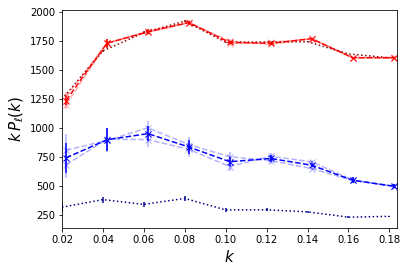

In [235]:
cs = ['r','y','b','orange','g']
c2s = ['darkred','y','darkblue','orange','g']

for l in [0,2]:
#     if l%2==0:
#         plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPkis],axis=0),
#                 yerr=k_cen*np.std([P['p%d'%l] for P in tPkis],axis=0)/np.sqrt(N_sim),
#             ls='-',marker='',c=c2s[l])
    # NO WINDOW
    plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPks],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in tPks],axis=0)/np.sqrt(N_sim),
            ls=':',marker='',c=c2s[l])
    # WINDOW
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
           yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
           ls='--',marker='x',c=cs[l])
    # WINDOW 5-fish-1
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksA],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPksA],axis=0)/np.sqrt(N_sim),
            ls='--',marker='x',c=cs[l],alpha=0.3)
    # WINDOW 5-fish-2
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksB],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPksB],axis=0)/np.sqrt(N_sim),
            ls='--',marker='x',c=cs[l],alpha=0.3)
    #plt.plot(k_cen,k_cen*interp1d(k_arr,k_arr**2*P0_arr)(k_cen)/np.asarray(k_cen)**2)
plt.xlim(min(k_cen),max(k_cen)*1.02)
#plt.ylim(-300,2000)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

## p_2 looks wrong??

### p2 seems to be biased from the window function?? this is not good!!! something strange may be going on / maybe defining things just from a GRF isn't correct?? could check with global geometry? or limit of that?

In [ ]:
cs = ['r','y','b','orange','g']
c2s = ['darkred','y','darkblue','orange','g']

for l in [0,2]:
#     if l%2==0:
#         plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPkis],axis=0),
#                 yerr=k_cen*np.std([P['p%d'%l] for P in tPkis],axis=0)/np.sqrt(N_sim),
#             ls='-',marker='',c=c2s[l])
    # NO WINDOW
    plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPks],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in tPks],axis=0)/np.sqrt(N_sim),
            ls=':',marker='',c=c2s[l])
    # WINDOW
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
           yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
           ls='--',marker='x',c=cs[l//2])
    # WINDOW 5-fish-1
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksA],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPksA],axis=0)/np.sqrt(N_sim),
            ls=':',marker='x',c=cs[l//2])
    # WINDOW 5-fish-2
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksB],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPksB],axis=0)/np.sqrt(N_sim),
            ls=':',marker='x',c=cs[l//2])
#     plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPkis],axis=0),
#            yerr=k_cen*np.std([P['p%d'%l] for P in fPkis],axis=0)/np.sqrt(N_sim),
#            ls=':',marker='.',c=cs[l//2])
plt.xlim(min(k_cen),max(k_cen)*1.02)
#plt.ylim(-300,2000)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

#### this is very weird, and probably bad....

Text(0,0.5,'$k\\,P_\\ell(k)$')

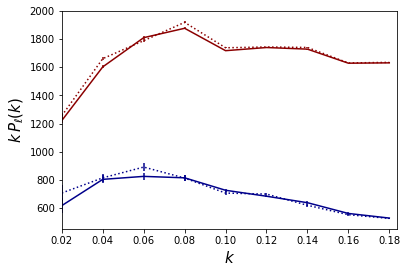

In [709]:
cs = ['r','y','b','orange','g']
c2s = ['darkred','y','darkblue','orange','g']

for l in [0,2]:
    if l%2==0:
        plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in fPkis],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in fPkis],axis=0)/np.sqrt(N_sim),
            ls='-',marker='',c=c2s[l])
#     plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
#                 yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
#             ls=':',marker='',c=c2s[l])
    plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
            ls=':',marker='',c=c2s[l])
    #plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
    #        yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
    #        ls='--',marker='x',c=cs[l//2])
#     plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksA],axis=0),
#             yerr=k_cen*np.std([P['p%d'%l] for P in fPksA],axis=0)/np.sqrt(N_sim),
#             ls=':',marker='x',c=cs[l//2])
#     plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksB],axis=0),
#             yerr=k_cen*np.std([P['p%d'%l] for P in fPksB],axis=0)/np.sqrt(N_sim),
#             ls=':',marker='x',c=cs[l//2])
#     plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPkis],axis=0),
#            yerr=k_cen*np.std([P['p%d'%l] for P in fPkis],axis=0)/np.sqrt(N_sim),
#            ls=':',marker='.',c=cs[l//2])
plt.xlim(min(k_cen),max(k_cen)*1.02)
#plt.ylim(-300,2000)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

Text(0,0.5,'$k\\,P_\\ell(k)$')

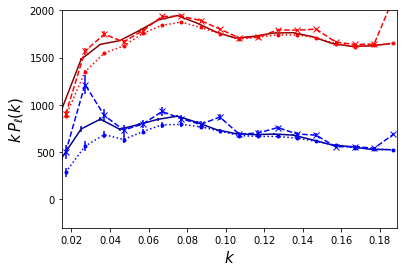

In [472]:
cs = ['r','b','g']
c2s = ['darkred','darkblue','darkgreen']

for l in [0,2]:
    plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPkis],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in tPkis],axis=0)/np.sqrt(N_sim),
            ls='-',marker='',c=c2s[l//2])
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
            ls='--',marker='x',c=cs[l//2])
#     plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksA],axis=0),
#             yerr=k_cen*np.std([P['p%d'%l] for P in fPksA],axis=0)/np.sqrt(N_sim),
#             ls=':',marker='x',c=cs[l//2])
#     plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPksB],axis=0),
#             yerr=k_cen*np.std([P['p%d'%l] for P in fPksB],axis=0)/np.sqrt(N_sim),
#             ls=':',marker='x',c=cs[l//2])
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPkis],axis=0),
           yerr=k_cen*np.std([P['p%d'%l] for P in fPkis],axis=0)/np.sqrt(N_sim),
           ls=':',marker='.',c=cs[l//2])
plt.xlim(min(k_cen),max(k_cen)*1.02)
plt.ylim(-300,2000)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

### repeat with lmax=2!

Text(0,0.5,'$k\\,P_\\ell(k)$')

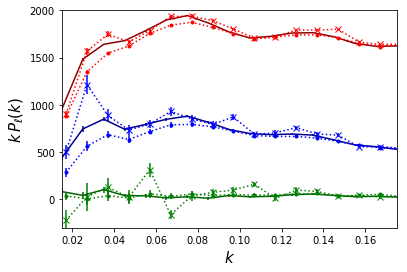

In [457]:
cs = ['r','b','g']
c2s = ['darkred','darkblue','darkgreen']

for l in [0,2,4]:
    plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in tPkis],axis=0),
                yerr=k_cen*np.std([P['p%d'%l] for P in tPkis],axis=0)/np.sqrt(N_sim),
            ls='-',marker='',c=c2s[l//2])
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0)/np.sqrt(N_sim),
            ls=':',marker='x',c=cs[l//2])
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPkis],axis=0),
            yerr=k_cen*np.std([P['p%d'%l] for P in fPkis],axis=0)/np.sqrt(N_sim),
            ls=':',marker='.',c=cs[l//2])
plt.xlim(min(k_cen),k_cen[-2])
plt.ylim(-300,2000)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)

### should we be dropping the pixellation stuff in the denominator?

(-300, 2000)

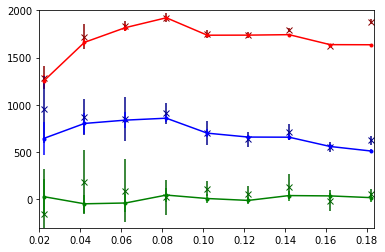

In [309]:
cs = ['r','b','g']
c2s = ['darkred','darkblue','darkgreen']
for l in [0,2,4]:
    #plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in fPkis],axis=0),
    #             yerr=k_cen*np.std([P['p%d'%l] for P in fPkis],axis=0),
    #         ls='',marker='.',c=c2s[l//2])
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in fPks],axis=0),
             yerr=k_cen*np.std([P['p%d'%l] for P in fPks],axis=0),
             ls='',marker='x',c=c2s[l//2])
    #plt.errorbar(k_cen,k_cen*np.mean([P['p%d'%l] for P in Pkis],axis=0),
    #             yerr=k_cen*np.std([P['p%d'%l] for P in Pkis],axis=0),
    #         ls=':',marker='.',c=cs[l//2])
    plt.errorbar(np.asarray(k_cen)+0.002,k_cen*np.mean([P['p%d'%l] for P in Pks],axis=0),
             yerr=k_cen*np.std([P['p%d'%l] for P in Pks],axis=0),
             ls='-',marker='.',c=cs[l//2])
    #plt.plot(k_arr,k_arr*Pk_theory[l//2+1],
    #         c=cs[l//2],alpha=0.5)
plt.xlim(min(k_cen),max(k_cen)*1.02)
plt.ylim(-300,2000)

### Optimal Estimators: BOSS Data

Next we test using the BOSS dataset. We first create a density field object containing the data, following the Nbodykit cookbook. Note that the gridsize is set according to a specified $k_{\rm max}$ value. Since we weight the data via the $\mathsf{S}^{-1}$ scheme, we *only* apply systematic weights at this step. The density field is normalized such that it gives the density of galaxies for each pixel -- this is somewhat arbitrary, but we must use the same convention for the mask. 

In [ ]:
### Load BOSS data
download_dir = '/Users/ophilcox/Documents/'

# NOTE: change this path if you downloaded the data somewhere else!
data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')
mask_path = os.path.join(download_dir, 'mask_DR12v5_LOWZ_South.ply')

# initialize the FITS catalog objects for data and randoms
cat = FITSCatalog(data_path)
cat_rand = FITSCatalog(randoms_path)

# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# add Cartesian position column
cat['Position'] = transform.SkyToCartesian(cat['RA'], cat['DEC'], cat['Z'], cosmo=cosmo)
cat_rand['Position'] = transform.SkyToCartesian(cat_rand['RA'], cat_rand['DEC'], cat_rand['Z'], cosmo=cosmo)

cat_rand['WEIGHT'] = 1.0
cat['WEIGHT'] = cat['WEIGHT_SYSTOT'] * (cat['WEIGHT_NOZ'] + cat['WEIGHT_CP'] - 1.0)

ZMIN = 0.15
ZMAX = 0.43

# slice the randoms
valid = (cat_rand['Z'] > ZMIN)&(cat_rand['Z'] < ZMAX)
cat_rand = cat_rand[valid]

# slice the data
valid = (cat['Z'] > ZMIN)&(cat['Z'] < ZMAX)
cat = cat[valid]

# Define box attributes
kmax = 0.2
boxsize = 1.2*(np.max(cat['Position'].compute(),axis=0)-np.min(cat['Position'].compute(),axis=0))
boxcenter = (np.max(cat['Position'].compute(),axis=0)+np.min(cat['Position'].compute(),axis=0))/2.
gridsize = np.asarray(np.ceil(1.2*kmax/(np.pi/boxsize)),dtype=int)

# Shift to box-center
cat['Position'] -= boxcenter
cat_rand['Position'] -= boxcenter

# Create data and random meshes
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['WEIGHT']).compute()/boxsize.prod()
mesh_rand = mesh_rand*np.sum(cat_rand['WEIGHT']).compute()/boxsize.prod()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Compute output as [data - alpha * randoms]
density_grid = (mesh_data - alpha*mesh_rand)

We also must create a mask, $n(\vec x)$. Here, we use the pixel-window-deconvolved random catalog for this, setting values to zero below some threshold. One could also use the SDSS-III "mangle" mask, but it is less clear if this closely matches the data distribution (including systematic effects).

# Create random mesh
rand_grid = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=True, position='Position',
                       weight='WEIGHT', resampler='tsc').compute()

# Normalize to match the data
rand_grid = np.asarray(rand_grid)*np.sum(cat['WEIGHT']).compute()/boxsize.prod()

In [ ]:
# # Zero any regions with very small values
# zero_filt = rand_grid<1e-3*np.asarray(rand_grid).mean()
# rand_grid[zero_filt] = 0.

# # Apply same filter to the data
# density_grid[zero_filt] = 0.

### removing zero filtering above!?

In [ ]:
# # Create data and random meshes
# cat['TOT_WEIGHT'] = cat['WEIGHT']*cat['WEIGHT_FKP']
# cat_rand['TOT_WEIGHT'] = cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']
# mesh_data2 = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=True, position='Position',
#                        weight='TOT_WEIGHT', resampler='tsc').compute()
# mesh_rand2 = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=True, position='Position',
#                        weight='TOT_WEIGHT', resampler='tsc').compute()

# # Normalize fields
# mesh_data2 = mesh_data2*np.sum(cat['TOT_WEIGHT']).compute()/boxsize.prod()
# mesh_rand2 = mesh_rand2*np.sum(cat_rand['TOT_WEIGHT']).compute()/boxsize.prod()

# # Compute output as [data - alpha * randoms]
# density_grid2 = (mesh_data2 - alpha*mesh_rand2)

In [ ]:
plotter(rand_grid,axis=1)
plotter(mask_grid,axis=1)

### can we just use the compensated randoms catalog as the mask??
### this probably will work in our formalism and yield better results??



### setting kmax = 0.2 above!

We now load the PolyBin3D object. This isn't directly used until later, but carries some useful attributes like the 3D radial grids that we'll use to construct the mask.

In [ ]:
# Define fiducial power spectrum (assuming the Kaiser formula)
# Using a better estimate of P(k) would result in a slightly more optimal estimator

# Create a simple galaxy power spectrum
redshift = 0.55
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
nbar = 3e-4
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class
base = PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )

We also must create a mask, $n(\vec x)$. This is done from the angular mask and the redshift-distribution of the randoms, and normalized such that the mean density matches that of the (weighted) data. Here, we use the "mangle" mask provided by SDSS-III, read-in via the "mangle" code: https://github.com/mollyswanson/manglepy/. (Note that the C/Fortran code isn't needed, though without it the code will be quite slow).

In [ ]:
mask_grid_file = 'lowz_south_mask_grid(%d,%d,%d).npz'%(gridsize[0],gridsize[1],gridsize[2])

# Load already precomputed mask if it exists!
if os.path.exists(mask_grid_file):
    print("Loadng precomputed mask")
    d = np.load(mask_grid_file)
    mask_grid = d['mask_grid']
    nz_interp = UnivariateSpline(d['z_av'],d['nVz'],s=0.000000001,ext='zeros')
    rescale = d['rescale']
    
# Compute from scratch
else:

    # First define RA, Dec, z coordinates on the Cartesian grid, using nbodykit
    print("Creating RA, Dec, z co-ordinate grid")
    from nbodykit.lab import transform
    ra_grid, dec_grid, z_grid = transform.CartesianToSky(np.asarray([r.ravel() for r in base.r_grids]).T,cosmo)
    z_grid = z_grid.compute().reshape(base.r_grids[0].shape)

    # Histogram the random n_z values, giving dN = n(z)*dz
    print("Computing n(z) distribution")
    nz,z = np.histogram(cat_rand['Z'].compute(),bins=100,weights=cat_rand['WEIGHT'].compute(),range=[ZMIN,ZMAX])
    z_av = 0.5*(z[:-1]+z[1:])
    rz = cosmo.comoving_distance(z)

    # Convert to volume density i.e. dN = n_V(z)dV
    volz = 4.*np.pi/3.*(rz[1:]**3.-rz[:-1]**3.)
    from scipy.interpolate import UnivariateSpline
    nz_interp = UnivariateSpline(z_av,nz/volz,s=0.000000001,ext='zeros')
    
    # Plot the distribution
    plt.plot(z_av, nz/volz, label='Measured')
    plt.plot(z_av, nz_interp(z_av), label='Interpolated')
    plt.xlabel(r'$z$',fontsize=15)
    plt.ylabel(r'$n_V(z)$',fontsize=15)
    plt.legend(fontsize=14);

    # Define angular mask, defined as a "mangle" mask
    import mangle
    print("Loading angular mask")
    mask = mangle.Mangle(mask_path)

    # Define n_V(z) on grid
    nz_grid = nz_interp(z_grid)
    
    # Define angular mask on grid, removing any points outside mask area
    ids = mask.get_polyids(ra_grid.ravel(),dec_grid.ravel())
    angular_weight_grid = mask.weights[ids]
    angular_weight_grid[ids==-1] = 0.
    angular_weights = angular_weight_grid.reshape(base.r_grids[0].shape)
    
    # Define total mask
    print("Assembling total mask")
    mask_grid = nz_grid*angular_weights
    
    # Normalize mask to galaxy density
    rescale = np.sum(cat['WEIGHT']).compute()/boxsize.prod()/np.mean(mask_grid)
    mask_grid *= rescale
    
    # Save the mask to avoid later re-computation
    np.savez(mask_grid_file,mask_grid=mask_grid,rescale=rescale,z_av=z_av,nVz=nz/volz)

Now, we can compute the power spectrum. We must specify the mask, $n(\vec x)$ and the weighting scheme $\mathsf{S}^{-1}$. This must take both real- and Fourier-space inputs, and apply some weighting in real- and/or Fourier-space. Ideally, $$\mathsf{S}^{-1} = \left[W\xi+\beta\mathsf{I}\right]^{-1}$$ for window operator $W$ and data two-point function operator $\xi$. If the mask contains holes or local lines-of-sight, this cannot be computed analytically. We can either use an approximate weighting $\mathsf{S}^{-1}$ (which does not bias the estimator), or compute the full solution with conjugate gradient descent. 

Here, we use an FKP-like weighting, assuming a uniform power spectrum amplitude $P_{\rm fkp}=10^4$. This gives $$[\mathsf{S}^{-1}u](\vec x) = \frac{1}{n(\vec x)P_{\rm fkp}+\beta}u(\vec x)$$

### define beta and use it later!!!

### should test if kfilt changes results!!



### check whether setting weight=0 outside mask is important!

### also check whether the choice of the mask is important!

### also check odd/even ell!



### using wide bins for testing!

In [ ]:
input_mask = rand_grid

beta = 1
P_fkp = 1e4

fkp_weight = 1./(input_mask*P_fkp+beta)*(input_mask!=0)

def applySinv_fkp(input_data, input_type='real', output_type='real'):
    """Apply an FKP-like filter to the data."""
   
    # Read in the data, and convert it to real-space if necessary
    if input_type=='fourier':
        input_real = base.to_real(input_data)
    else:
        input_real = input_data.copy()
    
    # Apply FKP weight
    output_real = input_real*fkp_weight
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return output_real
    else:
        return base.to_fourier(output_real)

In [ ]:
plotter(applySinv_fkp(density_grid))

In [ ]:
# Define some k-bins and ell_max
k_edges = np.arange(0.0063,0.245,0.02)
lmax = 4

# Load the power spectrum class
pspec = PSpec(base, k_edges, applySinv = applySinv_fkp, mask = input_mask, lmax = lmax, odd_l=False)

# Define the k-bin centers
k_cen = pspec.get_ks()

We'll first compute the normalization term, $\mathcal{F}$, (and shot-noise) using Monte Carlo methods. This can be expensive to compute, and should usually be paralellized. Here, we use 3 realizations for testing (10 is usually sufficient), computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method, which additionally allows for multi-processing.

In [ ]:
# Number of Monte Carlo iterations
N_it = 10

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output
fish = np.mean([f[0] for f in fish_and_shot],axis=0)
fish_sd = np.std([f[0] for f in fish_and_shot],axis=0)

shot_num = np.mean([f[1] for f in fish_and_shot],axis=0)
shot_num_sd = np.std([f[1] for f in fish_and_shot],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish, shot_num = pspec.compute_fisher(N_it, N_cpus=1, verb=True)

In [ ]:
fish1 = np.mean([f[0] for f in fish_and_shot[:5]],axis=0)
fish2 = np.mean([f[0] for f in fish_and_shot[5:]],axis=0)
fish = (fish1+fish2)/2.

In [ ]:
plt.errorbar(np.arange(pspec.N_bins),np.diag(fish),yerr=np.diag(fish_sd))

In [ ]:
pk1 = pspec.Pk_unwindowed(density_grid, fish=fish1, shot_num=shot_num, subtract_shotnoise=False)
pk2 = pspec.Pk_unwindowed(density_grid, fish=fish2, shot_num=shot_num, subtract_shotnoise=False)
pk = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)

cols2 = ['red','blue','green']
cols = ['darkred','purple','darkgreen']
for l in [0,2,4]:
    plt.errorbar(k_cen,k_cen*pk1['p%d'%l],c=cols[l//2],ls='--')
    plt.errorbar(k_cen,k_cen*pk2['p%d'%l],c=cols[l//2],ls=':')
    plt.errorbar(k_cen,k_cen*pk['p%d'%l],c=cols2[l//2],ls='-')

In [ ]:
# Compute unwindowed power spectrum
pk = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)
pk_ideal = pspec.Pk_ideal(density_grid)

## Print number of FFTs used, for diagnostics!
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

For comparison, let's also compute the window-convolved FKP power spectrum with Nbodykit

In [ ]:
# # Add an nz column for the catalog
# # Better to recompute this, since we use different fiducial cosmology!
# cat['nz'] = nz_interp(cat['Z'])*rescale
# cat_rand['nz'] = nz_interp(cat_rand['Z'])*rescale

# # Define FKP weights
# cat['fkp_weight'] = 1./(P_fkp*cat['nz']+beta)
# cat_rand['fkp_weight'] = 1./(P_fkp*cat_rand['nz']+beta)

# # Recompute the density-field with the pixel-window-compensation applied, and shifting along the line-of-sight
# cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
# cat_fkp_nb['data/Position'] += boxcenter
# cat_fkp_nb['randoms/Position'] += boxcenter
# density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, interlaced=True, 
#                                compensated=True,position='Position',
#                                fkp_weight='fkp_weight', comp_weight='WEIGHT', resampler='tsc')

# # Compute the Nbodykit power spectrum in the same bins
# r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
# pk_nb = r.poles

In [ ]:
cols = ['darkred','purple','darkgreen']
cols2 = ['red','blue','green']
for l in [0,2,4]:
    plt.errorbar(k_cen,k_cen*pk_nb['power_%d'%l].real,c=cols2[l//2],ls='--')
    plt.errorbar(k_cen,k_cen*pk['p%d'%l],c=cols[l//2],ls='-',yerr=np.abs(k_cen*pk1['p%d'%l]-k_cen*pk2['p%d'%l]))
    plt.errorbar(k_cen,k_cen*pk_ideal['p%d'%l],c=cols[l//2],ls=':')

cols = ['darkred','purple','darkgreen']
cols2 = ['red','blue','green']
for l in [0,2,4]:
    plt.errorbar(k_cen,k_cen*pk_nb['power_%d'%l].real,c=cols2[l//2],ls='--')
    plt.errorbar(k_cen,k_cen*pk['p%d'%l],c=cols[l//2],ls='-',yerr=np.abs(k_cen*pk1['p%d'%l]-k_cen*pk2['p%d'%l]))
    plt.errorbar(k_cen,k_cen*pk_ideal['p%d'%l],c=cols[l//2],ls=':')

### why is Pk-ideal very different to Pk-nb?
### and why is Pk so different to both? is this due to normalization?

### removing the zero-filtering thing with a rand-mask makes a very big difference??? - the Fisher seems very badly converged there!

In [700]:
p_guess = np.concatenate([interp1d(k_arr,P0_arr)(k_cen),interp1d(k_arr,P2_arr)(k_cen),interp1d(k_arr,P4_arr)(k_cen)])
q_guess = np.matmul(fish,p_guess)

In [705]:
p_guess2 = np.concatenate([interp1d(k_arr,P0_arr)(k_cen)*(k_cen<0.2),
                           interp1d(k_arr,P2_arr)(k_cen)*(k_cen<0.2),
                           interp1d(k_arr,P4_arr)(k_cen)*(k_cen<0.2)])
q_guess2 = np.matmul(fish,p_guess2)

In [706]:
q_obs = pspec.Pk_numerator(density_grid)

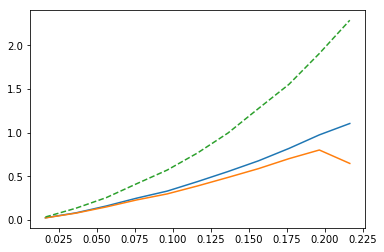

In [707]:
for i in [0]:
    plt.figure();
    plt.plot(k_cen,q_guess[i*pspec.Nk:(i+1)*pspec.Nk])
    plt.plot(k_cen,q_guess2[i*pspec.Nk:(i+1)*pspec.Nk])
    plt.plot(k_cen,q_obs[i*pspec.Nk:(i+1)*pspec.Nk],ls='--')

### could check the forward model, i.e. what scales already contribute e.g. at k=0.05

### check renormalization term

In [630]:
# Compute power-spectrum normalization factor
norm_dat = (cat['nz']*cat['WEIGHT']*cat['fkp_weight']**2.).sum().compute()

norm_cont = np.sum(mask_grid**2*fkp_weight**2)*boxsize.prod()/gridsize.prod()

In [631]:
norm_dat, norm_cont

(2.1568588441812944, 2.1959159003945716)

In [632]:
from scipy.special import legendre
fish_fkp = np.zeros((pspec.N_bins,pspec.N_bins))
for la in range(pspec.Nl):
    for lb in range(pspec.Nl):
        for i in range(pspec.Nk):
            fish_fkp[la*pspec.Nk+i,lb*pspec.Nk+i] = 0.5*np.sum(legendre(la*2)(pspec.muk_grid)*legendre(lb*2)(pspec.muk_grid)*pspec.all_k_filters[i]*pspec.all_k_filters[i])/gridsize.prod()**2*boxsize.prod()
fish_fkp *= np.sum(rand_grid**2*fkp_weight**2)*gridsize.prod()/boxsize.prod()

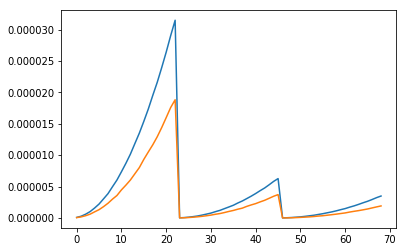

In [633]:
plt.plot(np.diag(fish_fkp))
plt.plot(np.diag(pspec.fish))

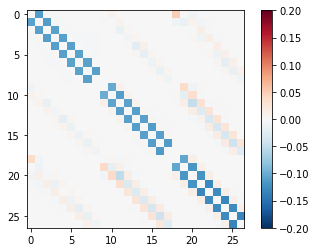

In [530]:
def plot_corr(f, v):
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    plt.imshow(cfish-np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();

plot_corr(pspec.inv_fish, 0.2)

### we get very different results with a (mask!=0) condition in filtering?!

### the mask is probably misspecified here!!

### compare runtime vs Nbodykit?

### this looks dodgy: can we try a fake data test??, i.e. one with same ordering of operations (e.g. pixelated data, deconvolved, then fkp weighted)

### variance definitely seems wrong!!

### our estimator numerator agrees with ideal estimator @ unit fiducial power and no FKP weight

### need to test + implement CGD code!

### add $\beta$ parameter!

### Optimal Estimators: Lognormal Mocks

We now test the optimal mask-deconvolved power spectrum estimators. For this, let's use a simple lognormal lightcone geometry. We first define the sample, creating a 3D density field which contains $n_g(\vec x)-\bar{n}$ (without additional normalization) and a mask $n(\vec x) = \bar{n}$.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nbodykit.lab import *

# Define a line-of-sight
los_vector = np.asarray([0.,1./np.sqrt(3.),np.sqrt(2./3.)])

# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0
fz = cosmo.scale_independent_growth_rate(redshift)
nbar = 3e-4

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Sample parameters
boxsize = 1000.
gridsize = 128

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)

# Add some redshift-space distortions along the line-of-sight [x -> x + (v.n)n]
cat['Position'] += np.sum(cat['VelocityOffset'] * los_vector, axis=1)[:,None]*los_vector
cat['Position'] %= boxsize
cat['Position'] -= boxsize/2. # center on zero

# Convert the catalog to a grid, with CIC interpolation and interlacing
density_grid = cat.to_mesh(compensated=False, BoxSize=boxsize, resampler='tsc', interlaced=True, position='Position').compute()
density_grid -= 1.

# Normalize density field to give *density* in each cell (like observational data)
density_grid *= nbar

# Define a mask, i.e. the background density field
constant_mask = nbar

Now we set up PolyBin3D. This works just as before, and we assume a lightcone geometry, with local redshift-space axes and a sample displaced along the line-of-sight.

In [3]:
import PolyBin3D as pb
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=los_vector*10000, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 5.77e+03, 8.16e+03] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc


For the power spectrum, we must additionally specify the mask, $n(\vec x)$ and the weighting scheme $\mathsf{S}^{-1}$. This must take both real- and Fourier-space inputs, and apply some weighting in real- and/or Fourier-space. Ideally, $$\mathsf{S}^{-1} = \left[W\xi+\mathsf{I}\right]^{-1}$$ for window operator $W$ and data two-point function operator $\xi$. If the mask contains holes or local lines-of-sight, this cannot be computed analytically. We can either use an approximate weighting $\mathsf{S}^{-1}$ (which does not bias the estimator), or compute the full solution with conjugate gradient descent. Here, we demonstrate a simple form for constant-everywhere mask, using the redshift-space power spectrum.

In [4]:
from scipy.interpolate import interp1d
from scipy.special import legendre

# Define the redshift-space power spectrum on the grid 
Pk_grid = interp1d(k_arr,P0_arr, bounds_error=False)(base.modk_grid)
Pk_grid += interp1d(k_arr,P2_arr, bounds_error=False)(base.modk_grid)*legendre(2)(base.muk_grid)
Pk_grid += interp1d(k_arr,P4_arr, bounds_error=False)(base.modk_grid)*legendre(4)(base.muk_grid)

# Invert safely
k_weighting = np.zeros_like(Pk_grid)
k_weighting[(Pk_grid!=0)&(~np.isnan(Pk_grid))] = 1./Pk_grid[(Pk_grid!=0)&(~np.isnan(Pk_grid))]

# Add mean density
k_weighting /= nbar

def applySinv_simple(input_data, input_type='real', output_type='real'):
    """Apply a filter to the data, including the pixel window function."""
   
    # Read in the data, and convert it to Fourier-space if necessary
    if input_type=='real':
        input_fourier = base.to_fourier(input_data)
    else:
        input_fourier = input_data.copy()
    
    # Apply Fourier-space weighting
    Sinv_fourier = input_fourier*k_weighting
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return base.to_real(Sinv_fourier)
    else:
        return Sinv_fourier

In [5]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.02)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = applySinv_simple, mask = constant_mask, lmax = lmax)

# Define the k-bin centers
k_cen = pspec.get_ks()


## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Binning: 19 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Generating spherical harmonics


We'll first compute the normalization term, $\mathcal{F}$, (and shot-noise) using Monte Carlo methods. This can be expensive to compute (particularly in the Yamamoto approximation, which requires many Fourier transforms), and should usually be paralellized. Here, we use 5 realizations for testing (10 is usually sufficient), computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method, which additionally allows for multi-processing.

In [6]:
# Number of Monte Carlo iterations
N_it = 3

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output
fish = np.mean([f[0] for f in fish_and_shot],axis=0)
fish_sd = np.std([f[0] for f in fish_and_shot],axis=0)

shot_num = np.mean([f[1] for f in fish_and_shot],axis=0)
shot_num_sd = np.std([f[1] for f in fish_and_shot],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish, shot_num = pspec.compute_fisher(N_it, N_cpus=1, verb=True)

Computing iteration 1 of 3
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 3
Computing iteration 3 of 3


We now compute the power spectrum, specifying the Fisher matrix and shot-noise numerator we just computed. We can optionally subtract off Poisson shot-noise from the estimator at this point. We'll also compute the ideal power spectrum estimator here for comparison.

In [8]:
# Compute unwindowed power spectrum
pk = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)

# Compute ideal power spectrum
pk_ideal = pspec.Pk_ideal(density_grid) # this normalizes the field by < mask^2 > 
fish_ideal = pspec.fish_ideal

Computing ideal Fisher matrix


Let's look at the Fisher matrix. The diagonal elements are similar to those of the ideal estimator, though the off-diagonals differ; this is because we have included anisotropy in the $\mathsf{S}^{-1}$ weighting (the optimal estimator just uses a monopole weighting), and will lead to our inverse Fisher closely approximating the true covariance. The noise can be reduced by using more Monte Carlo realizations to define the Fisher matrix; it scales as $1/N_{\rm it}$. 

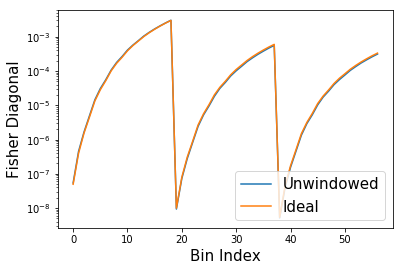

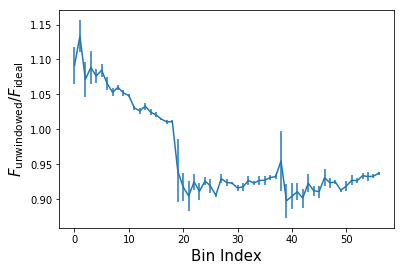

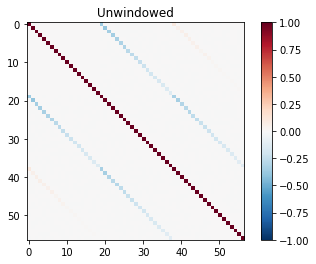

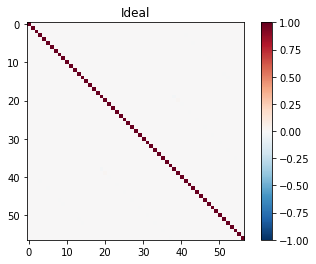

In [11]:
# Plot diagonals
plt.plot(np.diag(fish),label='Unwindowed')
plt.plot(np.diag(fish_ideal),label='Ideal')
plt.yscale('log')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'Fisher Diagonal',fontsize=15)
plt.legend(fontsize=15);

# Plot ratios
plt.figure()
plt.errorbar(np.arange(pspec.N_bins),np.diag(fish)/np.diag(fish_ideal),yerr=np.diag(fish_sd)/np.diag(fish_ideal))
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$F_{\rm unwindowed}/F_{\rm ideal}$',fontsize=15)

def plot_corr(f, v, title):
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    plt.title(title)
    plt.imshow(cfish,cmap=cm.RdBu_r,vmax=v,vmin=-v);plt.colorbar();

# Plot correlation matrices
plot_corr(fish, 1, 'Unwindowed')
plot_corr(fish_ideal, 1, 'Ideal')

Let's look at the spectra. We find excellent agreement for all correlators and for the shot-noise (which affects only the monopole, up to finite pixelation effects).

We note that these estimators are not *quite* identical in the uniform-mask limit. The unwindowed estimator additionally accounts for biases induced by the local line-of-sight, unlike the ideal estimator, which normalizes the power spectrum assuming the average line-of-sight to the sample. (In other words, the local 'Yamamoto' estimator is not strictly unbiased, even with a uniform window function.) Furthermore, and as above, our unwindowed estimator uses an anisotropic weighting, which is slightly closer to optimal than the isotropic weighting assumed in the ideal estimator.

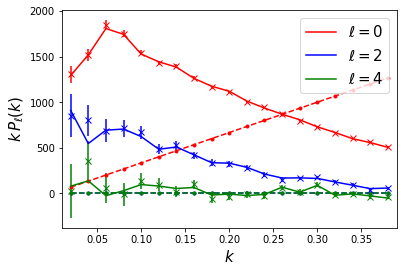

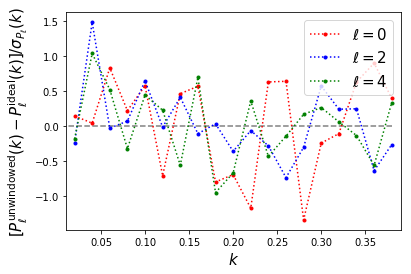

In [12]:
# Plot power spectra
ks = pspec.get_ks()
cs = ['r','b','g']
for l in [0,2,4]:
    plt.errorbar(ks,ks*(pk['p%d'%l]-(l==0)*1./nbar),color=cs[l//2],marker='x',ls='',
            yerr=ks*np.sqrt(np.diag(pspec.inv_fish))[l//2*pspec.Nk:(l//2+1)*pspec.Nk],)
    plt.plot(ks,ks*(pk_ideal['p%d'%l]-(l==0)*1./nbar),ls='-',color=cs[l//2],label=r'$\ell=%d$'%l)
    plt.plot(ks,ks*(pspec.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk]),color=cs[l//2],marker='.',ls='')
    plt.plot(ks,np.asarray(ks)/nbar*(l==0),ls='--',color=cs[l//2])
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)
plt.legend(fontsize=15,loc='upper right');
plt.xlim(min(k_edges),max(k_edges));

# Plot ratios
plt.figure()
for l in [0,2,4]:
    plt.errorbar(ks,(pk['p%d'%l]-pk_ideal['p%d'%l])/np.sqrt(np.diag(pspec.inv_fish))[l//2*pspec.Nk:(l//2+1)*pspec.Nk],
                 ls=':',marker='.',color=cs[l//2],label=r'$\ell=%d$'%l)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$[P_\ell^{\rm unwindowed}(k)-P_\ell^{\rm ideal}(k)]/\sigma_{P_\ell}(k)$',fontsize=15)
plt.legend(fontsize=15,loc='upper right');
plt.hlines(0,max(ks),0,linestyles='--',alpha=0.5,color='k')
plt.xlim(min(k_edges),max(k_edges));

Finally, let's test the optimality of the simulations, by computing a set of simulations and comparing the power spectrum variance to that from the inverse Fisher matrix. If the $\mathsf{S}^{-1}$ weighting is optimal, the inverse Fisher matrix should give the correct covariance matrix of the data. Here, we find excellent agreement, as expected (since our weighting $\mathsf{S}^{-1}$ is almost optimal [up to local line-of-sight effects]). Here, we test this using simple redshift-space Gaussian random field simulations with the theory power spectrum as input (with anisotropies along a global line-of-sight).

# Analyzing simulation 1 of 50
# Analyzing simulation 2 of 50
# Analyzing simulation 3 of 50
# Analyzing simulation 4 of 50
# Analyzing simulation 5 of 50
# Analyzing simulation 6 of 50
# Analyzing simulation 7 of 50
# Analyzing simulation 8 of 50
# Analyzing simulation 9 of 50
# Analyzing simulation 10 of 50
# Analyzing simulation 11 of 50
# Analyzing simulation 12 of 50
# Analyzing simulation 13 of 50
# Analyzing simulation 14 of 50
# Analyzing simulation 15 of 50
# Analyzing simulation 16 of 50
# Analyzing simulation 17 of 50
# Analyzing simulation 18 of 50
# Analyzing simulation 19 of 50
# Analyzing simulation 20 of 50
# Analyzing simulation 21 of 50
# Analyzing simulation 22 of 50
# Analyzing simulation 23 of 50
# Analyzing simulation 24 of 50
# Analyzing simulation 25 of 50
# Analyzing simulation 26 of 50
# Analyzing simulation 27 of 50
# Analyzing simulation 28 of 50
# Analyzing simulation 29 of 50
# Analyzing simulation 30 of 50
# Analyzing simulation 31 of 50
# Analyzing simul

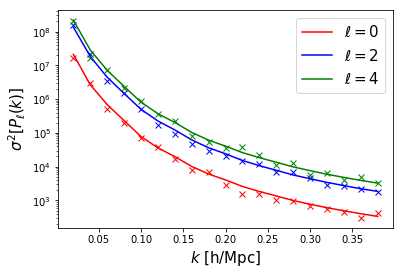

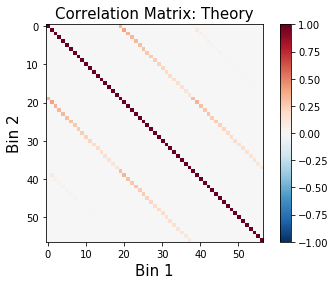

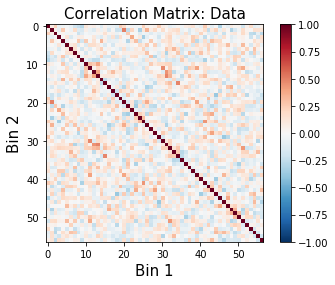

In [13]:
# Compute the empirical variances
pk_out_unwindowed = []

tot_sim = 50
for sim in range(tot_sim):
    print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    
    # Generate an anisotropic Gaussian random field density map
    density_grid = base.generate_data(sim, Pk_theory)*nbar
    
    # Compute the power spectra
    pk_out_unwindowed.append(pspec.Pk_unwindowed(density_grid, subtract_shotnoise=False))
    
# Compute variances
pk_var = {}
pk_var['p0'] = np.var([p['p0'] for p in pk_out_unwindowed],axis=0)
pk_var['p2'] = np.var([p['p2'] for p in pk_out_unwindowed],axis=0)
pk_var['p4'] = np.var([p['p4'] for p in pk_out_unwindowed],axis=0)

# Compute theoretical covariance
theory_covariance = pspec.inv_fish

# Plot variances
cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen,np.diag(theory_covariance)[l//2*pspec.Nk:(l//2+1)*pspec.Nk],c=cols[l//2],label=r'$\ell=%d$'%l)
    plt.plot(k_cen,pk_var['p%d'%l],c=cols[l//2],marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15)
plt.ylabel(r'$\sigma^2\left[P_\ell(k)\right]$',fontsize=15)
plt.legend(fontsize=15);

# Plot correlation matrix
plt.figure()
theory_corr = theory_covariance/np.sqrt(np.outer(np.diag(theory_covariance),np.diag(theory_covariance)))
v = 1.
plt.title('Correlation Matrix: Theory',fontsize=15)
plt.imshow(theory_corr, vmax=v, vmin=-v, cmap=cm.RdBu_r)
plt.xlabel(r'Bin 1',fontsize=15)
plt.ylabel(r'Bin 2',fontsize=15);
plt.colorbar();

# Compute variances
data_covariance = np.cov(np.asarray([np.hstack([p['p0'],p['p2'],p['p4']]) for p in pk_out_unwindowed]).T)

# Plot empirical matrix
plt.figure()
data_corr = data_covariance/np.sqrt(np.outer(np.diag(data_covariance),np.diag(data_covariance)))
v = 1.
plt.title('Correlation Matrix: Data',fontsize=15)
plt.imshow(data_corr, vmax=v, vmin=-v, cmap=cm.RdBu_r)
plt.xlabel(r'Bin 1',fontsize=15)
plt.ylabel(r'Bin 2',fontsize=15);
plt.colorbar();

We find excellent agreement, though note that the data covariance is very noisy.

### test on BOSS data using FKP weights and full CGD solution!

### test Thomas Floss optimizations: https://github.com/tsfloss/BFast. Can we make code *ultra*-fast?

### ask Thomas to collaborate??

## Simulation box testing

Let's make some fake simulation data with Nbodykit. Here, we draw a lognormal sample of galaxies, and interpolate them to a grid using standard techniques. This is normalized such that it represents the overdensity field, $\delta$. We could also feed in a continuous density field instead of the interpolated galaxy field (e.g. the matter density from a simulation, or a Gaussian random field).

In [9]:
from nbodykit.lab import *

# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0
fz = cosmo.scale_independent_growth_rate(redshift)
nbar = 3e-4

# Sample parameters
boxsize = 1000.
gridsize = 128

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)

# Add some redshift-space distortions along the z-axis
cat['Position'] += cat['VelocityOffset'] * [0,0,1]
cat['Position'] %= boxsize
cat['Position'] -= boxsize/2. # center on zero

# Convert the catalog to a grid, with CIC interpolation and interlacing
density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
density_grid -= 1.

Next, we load PolyBin3D. For this, we need to specify a fiducial power spectrum, which will be used as a weighting within each bin of the power spectrum estimator. We only use the monopole for weighting to avoid excess leakage between multipoles. 

We also need to decide the pixel window function, which accounts for the interpolation of discrete data onto the grid. The options are ``{'none','cic','tsc','pcs','interlaced-cic','interlaced-tsc','interlaced-pcs'}``. If no interpolation is used (e.g. for continuous simulation outputs), or if the density field is already pixel-window-corrected (e.g., using ``compensated=True`` above), then the pixel window should be set to ``'none'``.

In [11]:
# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class
import PolyBin3D as pb
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=[0,0,0], # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='global', # line-of-sight [global = z-axis, local = relative to pair]
                )

### An aside: we can use PolyBin3D to create Gaussian random fields with the fiducial redshift-space power spectrum:
# density_grid = base.generate_data(seed=42, Pk_input = Pk_theory, output_type='real')


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc


We can now proceed to compute power spectra. Here, we have periodic data without a mask, so we'll use the ``ideal`` power spectrum routines. These weight the data by $1/P_{{\rm fiducial},\ell=0}(k)$ to minimize noise.  Note that the ideal estimators do not subtract any shot-noise contributions.

In [13]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = None, lmax = lmax)

# Compute the ideal power spectrum
pk = pspec.Pk_ideal(density_grid)

# Define the k-bin centers
k_cen = pspec.get_ks()

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))


## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Computing ideal Fisher matrix
Computations complete using 2 forward and 0 reverse FFTs


Let's look at the power spectrum, and compare it to that from Nbodykit.

In [14]:
# Recompute the density-field with the pixel-window-compensation applied
density_mesh = cat.to_mesh(compensated=True, resampler='tsc', interlaced=True, position='Position')

# Compute the Nbodykit power spectrum in the same bins
r = FFTPower(density_mesh, mode='2d', kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
pk_nb = r.poles

(-1000, 2400)

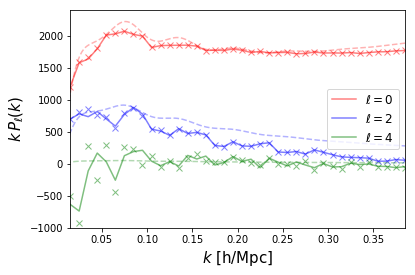

In [15]:
cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen, k_cen*pk['p%d'%l],label=r'$\ell=%d$'%l,c=cols[l//2],alpha=0.5,ls='-')
    plt.plot(k_cen, k_cen*pk_nb['power_%d'%l].real,c=cols[l//2],alpha=0.5,ls='',marker='x')
    plt.plot(Pk_theory[0], Pk_theory[0]*Pk_theory[l//2+1],c=cols[l//2],alpha=0.3,ls='--')
plt.legend(fontsize=12,loc='center right');
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15);
plt.xlim(min(k_cen),max(k_cen))
plt.ylim(-1000,2400)

The agreement between the two codes is excellent! Slight differences occur for the quadrupole and hexadecapole since PolyBin3D accounts for pixelation-induced leakage between different $\ell$-modes, which can be important at low-$k$.

We can also use PolyBin to compute the (Gaussian) covariance matrix, using the fiducial power spectrum monopole. This is shown below:

# Analyzing simulation 1 of 10
# Analyzing simulation 2 of 10
# Analyzing simulation 3 of 10
# Analyzing simulation 4 of 10
# Analyzing simulation 5 of 10
# Analyzing simulation 6 of 10
# Analyzing simulation 7 of 10
# Analyzing simulation 8 of 10
# Analyzing simulation 9 of 10
# Analyzing simulation 10 of 10


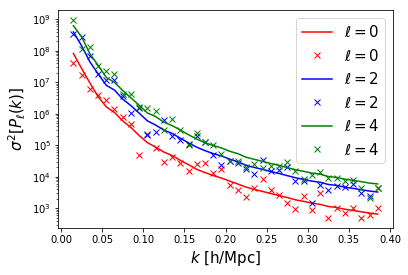

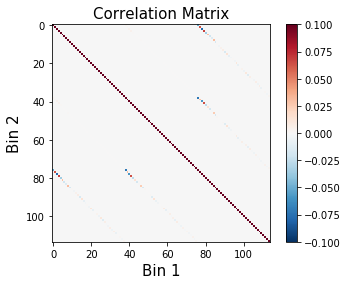

In [16]:
# Compute the empirical variances
pk_out = []
tot_sim = 10
for sim in range(tot_sim):
    print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=sim)

    # Add some redshift-space distortions along the z-axis
    cat['Position'] += cat['VelocityOffset'] * [0,0,1]
    cat['Position'] %= boxsize
    cat['Position'] -= boxsize/2. # center on zero

    # Convert the catalog to a grid, with CIC interpolation and interlacing
    density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
    density_grid -= 1.
    
    # Compute the power spectra
    pk_out.append(pspec.Pk_ideal(density_grid))

# Compute variances
pk_var = {}
pk_var['p0'] = np.var([p['p0'] for p in pk_out],axis=0)
pk_var['p2'] = np.var([p['p2'] for p in pk_out],axis=0)
pk_var['p4'] = np.var([p['p4'] for p in pk_out],axis=0)

# Compute theoretical covariance
theory_covariance = pspec.inv_fish_ideal

# Plot variances
for l in range(0,lmax+1,2):
    plt.plot(k_cen,np.diag(theory_covariance)[l//2*pspec.Nk:(l//2+1)*pspec.Nk],c=cols[l//2],label=r'$\ell=%d$'%l)
    plt.plot(k_cen,pk_var['p%d'%l],c=cols[l//2],label=r'$\ell=%d$'%l,marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15)
plt.ylabel(r'$\sigma^2\left[P_\ell(k)\right]$',fontsize=15)
plt.legend(fontsize=15);

# Plot correlation matrix
plt.figure()
theory_corr = theory_covariance/np.sqrt(np.outer(np.diag(theory_covariance),np.diag(theory_covariance)))
v = 0.1
plt.title('Correlation Matrix',fontsize=15)
plt.imshow(theory_corr, vmax=v, vmin=-v, cmap=cm.RdBu_r)
plt.xlabel(r'Bin 1',fontsize=15)
plt.ylabel(r'Bin 2',fontsize=15);
plt.colorbar();

The variances quite closely match the theoretical predictions (noting that we do not include contributions above the monopole). We also find slight off-diagonal correlation between multipoles even if there are no redshift-space distortions; this is induced by the pixelation effects (essentially the fact that $\int d\vec k\,L_\ell(\hat{k}\cdot\hat{z})L_{\ell'}(\hat{k}\cdot\hat{z})$ does not quite vanish for $\ell\neq \ell'$ on a finite grid).

## Light-cone testing (periodic)

We can also test on a light-cone like geometry. Here, we generate the catalog as before [as a periodic box centered at {0,0,0}, with redshift-space distortions along an arbitrary axis], but analyze it given some non-trivial ``boxcenter`` parameter, setting the center of the simulation volume.

In [17]:
from nbodykit.lab import *

# Define a line-of-sight
los_vector = np.asarray([0.,1./np.sqrt(3.),np.sqrt(2./3.)])

# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0
fz = cosmo.scale_independent_growth_rate(redshift)
nbar = 3e-4

# Sample parameters
boxsize = 1000.
gridsize = 128

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)

# Add some redshift-space distortions along the line-of-sight [x -> x + (v.n)n]
cat['Position'] += np.sum(cat['VelocityOffset'] * los_vector, axis=1)[:,None]*los_vector
cat['Position'] %= boxsize
cat['Position'] -= boxsize/2. # center on zero

# Convert the catalog to a grid, with CIC interpolation and interlacing
density_grid = cat.to_mesh(compensated=False, BoxSize=boxsize, resampler='tsc', interlaced=True, position='Position').compute()
density_grid -= 1.

We can load PolyBin3D as before, now specifying the ```boxcenter``` parameter (and using local lines-of-sight). 

In [18]:
# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=los_vector*1e4, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )

### An aside: we can use PolyBin3D to create Gaussian random fields with the fiducial redshift-space power spectrum multipoles
#density_grid = base.generate_data(seed=42, Pk_input = Pk_theory, output_type='real')


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 5.77e+03, 8.16e+03] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc


Let's compute the power spectrum as before:

In [20]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = None, lmax = lmax)

# Compute the ideal power spectrum
pk = pspec.Pk_ideal(density_grid)

# Define the k-bin centers
k_cen = pspec.get_ks()

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))


## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Generating spherical harmonics
Computing ideal Fisher matrix
Computations complete using 30 forward and 2 reverse FFTs


Let's compare to Nbodykit (which assumes the distant-observed approximation):

/opt/anaconda3/envs/nbodykit-env/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-1000, 2400)

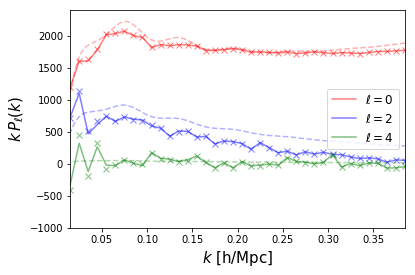

In [21]:
# Recompute the density-field with the pixel-window-compensation applied
density_mesh = cat.to_mesh(compensated=True, resampler='tsc', interlaced=True, BoxSize=boxsize, position='Position')

# Compute the Nbodykit power spectrum in the same bins
r = FFTPower(density_mesh, mode='2d', los=los_vector,
             kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
pk_nb = r.poles

cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen, k_cen*pk['p%d'%l],label=r'$\ell=%d$'%l,c=cols[l//2],alpha=0.5,ls='-')
    plt.plot(k_cen, k_cen*pk_nb['power_%d'%l],c=cols[l//2],alpha=0.5,ls='',marker='x')
    plt.plot(Pk_theory[0], Pk_theory[0]*Pk_theory[l//2+1],c=cols[l//2],alpha=0.3,ls='--')
plt.legend(fontsize=12,loc='center right');
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15);
plt.xlim(min(k_cen),max(k_cen))
plt.ylim(-1000,2400)

Once again, we'll compare covariances:

# Analyzing simulation 1 of 10
# Analyzing simulation 2 of 10
# Analyzing simulation 3 of 10
# Analyzing simulation 4 of 10
# Analyzing simulation 5 of 10
# Analyzing simulation 6 of 10
# Analyzing simulation 7 of 10
# Analyzing simulation 8 of 10
# Analyzing simulation 9 of 10
# Analyzing simulation 10 of 10


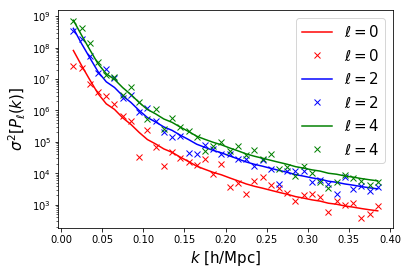

In [22]:
# Compute the empirical variances
pk_out = []
tot_sim = 10
for sim in range(tot_sim):
    print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=sim)

    # Add some redshift-space distortions along the z-axis
    cat['Position'] += np.sum(cat['VelocityOffset'] * los_vector, axis=1)[:,None]*los_vector
    cat['Position'] %= boxsize
    
    # Convert the catalog to a grid, with CIC interpolation and interlacing
    density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
    density_grid -= 1.
    
    # Compute the power spectra
    pk_out.append(pspec.Pk_ideal(density_grid))

# Compute variances
pk_var = {}
pk_var['p0'] = np.var([p['p0'] for p in pk_out],axis=0)
pk_var['p2'] = np.var([p['p2'] for p in pk_out],axis=0)
pk_var['p4'] = np.var([p['p4'] for p in pk_out],axis=0)

# Compute theoretical covariance
theory_covariance = pspec.inv_fish_ideal

# Plot variances
for l in range(0,lmax+1,2):
    plt.plot(k_cen,np.diag(theory_covariance)[l//2*pspec.Nk:(l//2+1)*pspec.Nk],c=cols[l//2],label=r'$\ell=%d$'%l)
    plt.plot(k_cen,pk_var['p%d'%l],c=cols[l//2],label=r'$\ell=%d$'%l,marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15)
plt.ylabel(r'$\sigma^2\left[P_\ell(k)\right]$',fontsize=15)
plt.legend(fontsize=15);

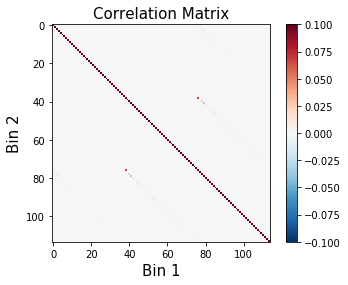

In [23]:
# Plot correlation matrix
plt.figure()
theory_corr = theory_covariance/np.sqrt(np.outer(np.diag(theory_covariance),np.diag(theory_covariance)))
v = 0.1
plt.title('Correlation Matrix',fontsize=15)
plt.imshow(theory_corr, vmax=v, vmin=-v, cmap=cm.RdBu_r)
plt.xlabel(r'Bin 1',fontsize=15)
plt.ylabel(r'Bin 2',fontsize=15);
plt.colorbar();

### Lightcone: FKP Weighting

Below, we show how to use PolyBin to compute the usual FKP pseudo-power spectra. This is done with the ```pspec.Pk_ideal``` function, but with careful choice of the input map and normalization. We give two ways to construct the input map (giving the galaxy density, $n(x)\delta_g(x)/\bar{n}$ at each point: using Nbodykit's FKP function, or using the catalogs directly.

We start by creating some fake data, here a lognormal catalog at a given distance from the origin.

In [24]:
# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
nbar = 3e-5
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define line-of-sight
los_vector = np.asarray([0.,np.sqrt(2./3.),np.sqrt(1./3.)])
boxcenter = cosmo.comoving_distance(redshift)*los_vector

# Sample parameters
boxsize = [1000.,1000.,1000.]
gridsize = [128,128,128]

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)
assert gridsize[0]==gridsize[1]==gridsize[2], "Lognormals need cubic geometries!"
assert boxsize[0]==boxsize[1]==boxsize[2], "Lognormals need cubic geometries!"

# Add some redshift-space distortions along the line-of-sight [x -> x + (v.n)n]
cat['Position'] += np.sum(cat['VelocityOffset'] * los_vector, axis=1)[:,None]*los_vector
cat['Position'] %= boxsize
cat['Position'] -= np.asarray(boxsize)/2. # center on zero

# Create a uniform catalog of randoms
cat_rand = UniformCatalog(nbar*50,boxsize,42)
cat_rand['Position'] -= np.asarray(boxsize)/2. # center on zero

# Add weight attributes
cat['WEIGHT_FKP'] = 1.+0.*cat['Position'][:,0]
cat['WEIGHT'] = 1.+0.*cat['Position'][:,0]
cat['NZ'] = np.sum(cat['WEIGHT'])/np.asarray(boxsize).prod()+0.*cat['Position'][:,0]
cat_rand['WEIGHT_FKP'] = 1.+0.*cat_rand['Position'][:,0]
cat_rand['WEIGHT'] = 1.+0.*cat_rand['Position'][:,0]
cat_rand['NZ'] = np.sum(cat['WEIGHT'])/np.asarray(boxsize).prod()+0.*cat_rand['Position'][:,0]

cat['TOT_WEIGHT'] = cat['WEIGHT']*cat['WEIGHT_FKP']
cat_rand['TOT_WEIGHT'] = cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']

Now, we can compute the FKP (pseudo-)power spectra using PolyBin3D. For this, we will add a normalization factor to the density field, reflecting the usual power spectrum normalization. This is given by
$$\sum_{i\,\in\,\mathrm{data}} n_i w_{{\rm sys},i} w_{{\rm fkp},i}^2,$$ which replaces the usual normalization. Note that this is specific to power spectra; bispectra have a different normalization!!

##### Create FKP field with nbodykit

In [25]:
## Create an FKP catalog with specified box-size
# Note that we don't include and zero-padding here, and set the box-center to zero: this will be handled later by PolyBin
# We're ust using Nbodykit to make a cube to analyze
cat_fkp = FKPCatalog(cat, cat_rand, BoxSize=boxsize, BoxPad=0.)

mesh_fkp = cat_fkp.to_mesh(Nmesh=gridsize, BoxCenter=0., interlaced=True, compensated=False,position='Position',
                   fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', resampler='tsc')

# Paint the FKP density field to the mesh
density_fkp = np.asarray(mesh_fkp.compute())*np.asarray(boxsize).prod()

# Compute power-spectrum normalization factor
norm_dat = (cat['NZ']*cat['WEIGHT']*cat['WEIGHT_FKP']**2.).sum().compute()
alpha = np.sum(cat['WEIGHT']).compute()/np.sum(cat_rand['WEIGHT']).compute()
norm_rand = (alpha*cat_rand['NZ']*cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']**2.).sum().compute()
assert np.allclose(norm_dat, norm_rand), "Data and randoms must be consistently weighted!"

print("Power spectrum (re)normalization factor: %.2f"%(np.sqrt(norm_dat*np.asarray(boxsize).prod())/np.sum(cat['WEIGHT']).compute()))

# Apply normalization
density_fkp = density_fkp/np.sqrt(norm_dat*np.asarray(boxsize).prod())

Power spectrum (re)normalization factor: 1.00


##### Create FKP field manually

In [26]:
# Create data and uniform meshs
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['TOT_WEIGHT']).compute()
mesh_rand = mesh_rand*np.sum(cat_rand['TOT_WEIGHT']).compute()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Compute output as [data - alpha * randoms]
density_fkp = (mesh_data - alpha*mesh_rand)

# Compute power-spectrum normalization factor
norm_dat = (cat['NZ']*cat['WEIGHT']*cat['WEIGHT_FKP']**2.).sum().compute()
alpha = np.sum(cat['WEIGHT']).compute()/np.sum(cat_rand['WEIGHT']).compute()
norm_rand = (alpha*cat_rand['NZ']*cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']**2.).sum().compute()
assert np.allclose(norm_dat, norm_rand)

# Apply normalize
density_fkp = density_fkp/np.sqrt(norm_dat*np.asarray(boxsize).prod())

print("Power spectrum (re)normalization factor: %.2f"%(np.sqrt(norm_dat*np.asarray(boxsize).prod())/np.sum(cat['WEIGHT']).compute()))

Power spectrum (re)normalization factor: 1.00


Now, we load PolyBin3D as before. We need to specify the center of the simulation box, and use ```local``` lines-of-sight (i.e. the Yamamoto approximation). Since we've applied the FKP normalization factor above, the rest of the computation proceeds exactly as before, using the ```pspec.Pk_ideal``` function.

In [29]:
# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )

# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = None, lmax = lmax)

# Compute the ideal power spectrum
pk = pspec.Pk_ideal(np.asarray(density_fkp))

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Define the k-bin centers
k_cen = pspec.get_ks()


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 1.17e+03, 8.26e+02] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc

## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Generating spherical harmonics
Computing ideal Fisher matrix
Computations complete using 15 forward and 1 reverse FFTs


We can compare this to the standard Nbodykit estimator:

In [30]:
# Recompute the density-field with the pixel-window-compensation applied, and shifting along the line-of-sight
cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
cat_fkp_nb['data/Position'] += boxcenter
cat_fkp_nb['randoms/Position'] += boxcenter
density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, interlaced=True, 
                               compensated=True,position='Position',
                               fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', resampler='tsc')

# Compute the Nbodykit power spectrum in the same bins
r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
pk_nb = r.poles

Let's plot the result (subtracting shot-noise):

(0.015, 0.385)

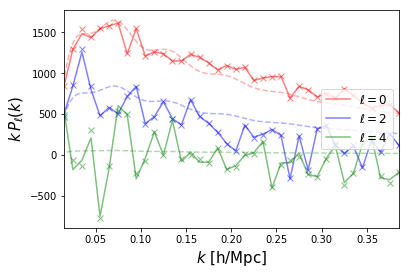

In [31]:
cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen, k_cen*(pk['p%d'%l]-(l==0)/nbar),label=r'$\ell=%d$'%l,c=cols[l//2],alpha=0.5,ls='-')
    plt.plot(k_cen, k_cen*(pk_nb['power_%d'%l]-(l==0)/nbar),c=cols[l//2],alpha=0.5,ls='',marker='x')
    plt.plot(Pk_theory[0], Pk_theory[0]*(Pk_theory[l//2+1]-(l==0)/nbar),c=cols[l//2],alpha=0.3,ls='--')
plt.legend(fontsize=12,loc='center right');
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15);
plt.xlim(min(k_cen),max(k_cen))

The agreement is excellent, as before! The only differences are from the treatment of pixelation artefacts, which are a very small low-k effect. 

### Lightcone: BOSS

Now, we repeat for the BOSS LOWZ-South dataset, analyzing as before. Here, we take care to define the boxsize and gridsize parameters. Most of the code below is just loading in the dataset (copied from Nbodykit's cookbook).

In [33]:
### Load BOSS data
download_dir = '/Users/ophilcox/Documents/'

# NOTE: change this path if you downloaded the data somewhere else!
data_path = os.path.join(download_dir, 'galaxy_DR12v5_LOWZ_South.fits')
randoms_path = os.path.join(download_dir, 'random0_DR12v5_LOWZ_South.fits')

# initialize the FITS catalog objects for data and randoms
cat = FITSCatalog(data_path)
cat_rand = FITSCatalog(randoms_path)

# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.676).match(Omega0_m=0.31)

# add Cartesian position column
cat['Position'] = transform.SkyToCartesian(cat['RA'], cat['DEC'], cat['Z'], cosmo=cosmo)
cat_rand['Position'] = transform.SkyToCartesian(cat_rand['RA'], cat_rand['DEC'], cat_rand['Z'], cosmo=cosmo)

cat_rand['WEIGHT'] = 1.0
cat['WEIGHT'] = cat['WEIGHT_SYSTOT'] * (cat['WEIGHT_NOZ'] + cat['WEIGHT_CP'] - 1.0)

ZMIN = 0.15
ZMAX = 0.43

# slice the randoms
valid = (cat_rand['Z'] > ZMIN)&(cat_rand['Z'] < ZMAX)
cat_rand = cat_rand[valid]

# slice the data
valid = (cat['Z'] > ZMIN)&(cat['Z'] < ZMAX)
cat = cat[valid]

# Add total weight
cat['TOT_WEIGHT'] = cat['WEIGHT']*cat['WEIGHT_FKP']
cat_rand['TOT_WEIGHT'] = cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']

# Define box attributes
boxsize = 1.2*(np.max(cat['Position'].compute(),axis=0)-np.min(cat['Position'].compute(),axis=0))
boxcenter = (np.max(cat['Position'].compute(),axis=0)+np.min(cat['Position'].compute(),axis=0))/2.
gridsize = np.asarray(np.ceil(1.2*k_edges[-1]/(np.pi/boxsize)),dtype=int)

# Shift to box-center
cat['Position'] -= boxcenter
cat_rand['Position'] -= boxcenter

Now, we'll create a 3D grid of BOSS data. Whilst we can do all this inside the Nbodykit ```FKP``` class, below we show it explicitly for general use beyond Nbodykit.

In [34]:
# Create data and uniform meshs
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['TOT_WEIGHT']).compute()
mesh_rand = mesh_rand*np.sum(cat_rand['TOT_WEIGHT']).compute()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Compute output as [data - alpha * randoms]
density_fkp = (mesh_data - alpha*mesh_rand)

# Compute power-spectrum normalization factor
norm_dat = (cat['NZ']*cat['WEIGHT']*cat['WEIGHT_FKP']**2.).sum().compute()
alpha = np.sum(cat['WEIGHT']).compute()/np.sum(cat_rand['WEIGHT']).compute()
norm_rand = (alpha*cat_rand['NZ']*cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']**2.).sum().compute()

assert np.allclose(norm_dat, norm_rand, rtol=1e-3)

# Apply normalize
density_fkp = density_fkp/np.sqrt(norm_dat*np.asarray(boxsize).prod())

print("Power spectrum (re)normalization factor: %.2f"%(np.sqrt(norm_dat*np.asarray(boxsize).prod())/np.sum(cat['WEIGHT']).compute()))

Power spectrum (re)normalization factor: 0.55


### should redefine NZ and FKP here!!

Now we compute the power spectrum, first defining some fiducial spectrum as a weighting [where only the monopole is used in the ideal estimators]. Then we run PolyBin3D as before.

In [36]:
# Define fiducial power spectrum (assuming the Kaiser formula)
# Using a better estimate of P(k) would result in a slightly more optimal estimator

# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
nbar = 3e-4
b1 = 1.8
fz = cosmo.scale_independent_growth_rate(redshift)

# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )

# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = None, lmax = lmax)

# Compute the ideal power spectrum
pk = pspec.Pk_ideal(np.asarray(density_fkp))

## Print number of FFTs used for diagnostics
print("Computations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))

# Define the k-bin centers
k_cen = pspec.get_ks()


# Dimensions: [1.01e+03, 1.91e+03, 1.06e+03] Mpc/h
# Center: [7.32e+02, 1.49e+01, 2.31e+02] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [151, 285, 159]
# Fundamental frequency: [0.006, 0.003, 0.006] h/Mpc
# Nyquist frequency: [0.469, 0.470, 0.471] h/Mpc
# Pixel window: interlaced-tsc

## Caution: k_max is greater than k_Nyquist/2; this might cause distortions.
Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Generating spherical harmonics
Computing ideal Fisher matrix
Computations complete using 15 forward and 1 reverse FFTs


Let's compare to Nbodykit:

In [37]:
# Recompute the density-field with the pixel-window-compensation applied, and shifting along the line-of-sight
cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
cat_fkp_nb['data/Position'] += boxcenter
cat_fkp_nb['randoms/Position'] += boxcenter
density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, 
                                  interlaced=True, 
                                compensated=True,position='Position',
                               fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', resampler='tsc')

# Compute the Nbodykit power spectrum in the same bins
r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
pk_nb = r.poles

(0.015, 0.385)

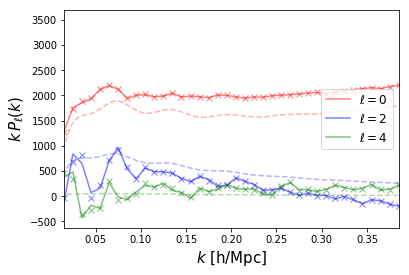

In [38]:
cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen, k_cen*pk['p%d'%l],label=r'$\ell=%d$'%l,c=cols[l//2],alpha=0.5,ls='-')
    plt.plot(k_cen, k_cen*pk_nb['power_%d'%l],c=cols[l//2],alpha=0.5,ls='',marker='x')
    plt.plot(Pk_theory[0], Pk_theory[0]*Pk_theory[l//2+1],c=cols[l//2],alpha=0.3,ls='--')
plt.legend(fontsize=12,loc='center right');
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15);
plt.xlim(min(k_cen),max(k_cen))

We caution that the inverse Fisher matrix will not be a great proxy for the covariance in this case, due to the complex weighting schemes utilized. This can be fixed with unwindowed estimators.

## TODO:
- use half k-grids since real?
- optimize code if possible!
- then add windows etc.
- add note on binning theory?

### Ideal Limits
- We define $P(k,\mu) \approx \sum_{b,\ell} p_{b,\ell} \Theta_b(k)L_\ell(\mu)$ for some bins $b$